In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
from scipy import integrate
from scipy.interpolate import interp1d 
from classy import Class
import math as math
%matplotlib inline
import sys, platform, os
import re
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import camb
from camb import model, initialpower

In [4]:
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True

plt.rcParams['axes.linewidth'] = 1.4

In [5]:
#class, want to get the stuff all from camb though
cosmo = Class()
cosmo.compute()
background = cosmo.get_background()

In [6]:
#table 1 from P&Y 1807.07076
euclid_data = np.loadtxt('tabula-1807.07076v2 porciani.txt')

In [7]:
#Fiducial cosmological parameters
c=3e5
hubble=0.678
omegab=0.022*pow(hubble,-2)
omegac=0.119*pow(hubble,-2)
om0=omegac+omegab
H00=100*hubble
Ass=2.14e-9
nss = 0.968
gamma=0.545

In [8]:
#table 1 from P&Y has columns z, V, ng, b1, b2, bs, M
z_euclid = euclid_data[:,0]
v_euclid =  interp1d(z_euclid,10.0 * (1.0/(hubble**3)) * 1e9 *euclid_data[:,1])
ng_euclid = interp1d(z_euclid, 1e-3 * hubble**3 * euclid_data[:,2])
b1_euclid = interp1d(z_euclid, euclid_data[:,3])
b2_euclid = interp1d(z_euclid, euclid_data[:,4])
bs_euclid = interp1d(z_euclid, euclid_data[:,5])

In [9]:
#Set up the fiducial cosmology
pars = camb.CAMBparams()
#Set cosmology
pars.set_cosmology(H0=H00, ombh2=omegab*pow(hubble,2), omch2=omegac*pow(hubble,2),omk=0,mnu=0)
pars.set_dark_energy() #LCDM (default)
pars.InitPower.set_params(ns=nss, r=0, As=Ass)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [10]:
#calculate results for these parameters
results = camb.get_results(pars)
background = camb.get_background(pars)

In [11]:
#Get matter power spectrum at z=zbin

zbin = 0.0

pars.set_matter_power(redshifts=[zbin], kmax=2.0)
#Use linear modelling
pars.NonLinear = model.NonLinear_none

#Non-Linear spectra (Halofit)
#pars.NonLinear = model.NonLinear_both

results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=2.0, npoints = 10000)
s8 = np.array(results.get_sigma8())
#print(results.get_sigma8())


In [12]:
#Pm in Mpc^3 units 
#Pm = interp1d(kh*hubble, pk[0]/pow(hubble,3))
Pmz0=interp1d(kh*hubble, (pk[0]/pow(hubble,3)))

In [13]:
#Define E(z) = H(z)/H0
def Ez(zc):
    return np.sqrt(1-om0+om0*pow(1+zc,3))
#Define the comoving distance
def drdz(zp):
    return (c/H00)/Ez(zp)
def rcom(zc):
    return sp.integrate.romberg(drdz,0,zc)

In [14]:
#Define the growth function in LCDM
def get_growth(zz):
    omz=om0*pow(1+zz,3)/(om0*pow(1+zz,3)+1-om0)
    return pow(omz,gamma)


In [15]:
#Get the growth factor 
def Dg_dz(zz):
    return get_growth(zz)/(1+zz)
def Dgz(zc):
    ans = sp.integrate.romberg(Dg_dz, 0.0, zc)
    return np.exp(-ans)


In [16]:
#Power spectrum as fn of z 
def Pmz(kk,zc):    
    return pow(Dgz(zc),2)*Pmz0(kk)

In [17]:
k1=None
k2=None
k3=None
d= dict([(12,k1), (22,k1),(3,k3)])

In [18]:
def k(i):
    return d[i]

In [19]:
k(1,2)

TypeError: k() takes 1 positional argument but 2 were given

In [20]:
k1=0.1

In [21]:
global Hu, H0, om_m0, om_m, f, df, dHu, ddHu, chi, cap_L, partdQ, gamma1, gamma2, partdb1, fnl, b1, db1, b2, b_e, Q, dQ

In [22]:
def set_params(z, bias):
    Hu = cosmo.Hubble(z)*(1/(1+z))
    H0 = cosmo.Hubble(0)
    om_m0 = 0.308
    om_m = om_m0 * (H0**2/Hu**2) *(1+z)
    f = cosmo.scale_independent_growth_factor_f(z)
    df = Hu* ((1/2)*(3*om_m -4)*f - f**2 + (3/2)*om_m)
    dHu = H0**2 * (-(1/2)* (1+z) * om_m0 + (1/(1+z))**2 * (1-om_m0))
    ddHu = H0**2 * ( (1/2)*Hu*(1+z)*om_m0 + (1/(1+z))**2 * 2 * Hu * (1-om_m0) )
    chi = cosmo.angular_distance(z)*(1+z)
    cap_L = 1
    partdQ=0
    if bias==1: #euclid
        b1= 0.9+0.4 *z
        db1= -0.4*Hu*(1+z)
        b2=-0.704172 - 0.207993*z + 0.183023*z**2 - 0.00771288*z**3
        b_e=-4
        db_e=0
        Q=(-1.0)*(-0.66 - 2.95*z + 1.59*z**2 - 0.40*z**3 + 0.04*z**4)
        dQ= 0
    elif bias==2: #ska
        b1=0.750+0.087*z + 0.019*z**2 
        b2=-0.257 - 0.063*z - 0.007*z**2 + 0.006*z**3
        db1= (0.0580776 + 0.0751623*z - 0.00891*z**2 + 0.000826*z**3)*(-(1+z)*Hu)#-0.087*Hu*(1+z) - 0.019*2*z*Hu*(1+z)
        b_e = -0.5#-0.000274 + 0.0000282*z-0.0000107*z**2 + 3.828e-6 * z**3
        db_e = 0*(0.0000809 - 0.000130*z + 0.0000596*z**2 - 6.00e-6*z**3)*(-(1+z))#-0.0000282*Hu*(1+z) + 0.0000107*2*z*Hu*(1+z) + 3.828e-6 * z**2 * 3 * Hu*(1+z)
        Q=1
        dQ=0    
    else: #simple bias for comparison
        b1=math.sqrt(1+z)
        db1=-0.5*Hu*math.sqrt(1+z)
        b2=-0.3*math.sqrt(1+z)
        b_e=0
        db_e=0
        Q=0
        dQ=0
    gamma1 = Hu* (f * (b_e - 2*Q -(2*(1-Q)/(chi*Hu)) - (dHu/Hu**2)))
    gamma2 = Hu**2 * (f*(3-b_e) + (3/2)*om_m*(2+b_e - f- 4*Q - (2*(1-Q)/(chi*Hu)) - (dHu/Hu**2) ))
    partdb1 = 0 
    fnl=0
    return Hu, H0, om_m0, om_m, f, df, dHu, ddHu, chi, cap_L, partdQ, gamma1, gamma2, partdb1, fnl, b1, db1, b2, b_e, db_e, Q, dQ

In [23]:
#galaxy bispectrum (what's up with the kernel squared, Chris?)
def ps_g(z, k, mu):
    Hu, H0, om_m0, om_m, f, df, dHu, ddHu, chi, cap_L, partdQ, gamma1, gamma2, partdb1, fnl, b1, db1, b2, b_e, db_e, Q, dQ = set_params(z, 1)
    pg = (b1 + f*mu**2)**2 * Pmz(k,z)
    return pg

In [24]:
ps_g(2.0, 0.1, 1)

13412.012105036536

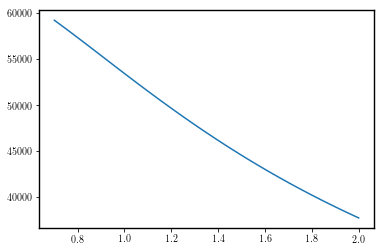

In [25]:
ztab=np.array(np.linspace(0.701,2.0))
p2tab=np.array([ps_g(z,0.05,1.0) for z in ztab])

plt.plot(ztab,p2tab)
plt.show()

TypeError: only size-1 arrays can be converted to Python scalars

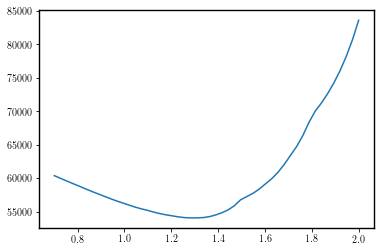

In [27]:
ztab = np.array(np.linspace(0.701, 2.0))

ptab = np.array([(ps_g(z,0.05,1.0) + 1.0/ng_euclid(z)) for z in ztab])

plt.plot(ztab,ptab)
plt.show()

In [28]:
def snr_ps(kmin,kmax,zmin,zmax,n_kbins,n_zbins,n_mubins):
    deltamu = 2.0/n_mubins
    deltak = (kmax-kmin)/n_kbins
    deltaz = (zmax-zmin)/n_zbins
    k = kmin
    z = zmin
    mu = -1.0
    res=0.0
    for zstep in np.arange((zmin+(deltaz/2.0)), zmax, deltaz):
        for mustep in np.arange(-1.0, 1.0, deltamu):
            for kstep in np.arange(kmin, kmax, deltak):
                res =res + ((1.0/8.0)*v_euclid(zstep) * deltaz * kstep**2 * deltak * (deltamu)  * ps_g(zstep,kstep,mustep)**2 )/(math.pi**2 *(ps_g(zstep,kstep,mustep) + (1.0/ng_euclid(zstep)))**2)
    return math.sqrt(res)

In [29]:
snr_ps(0.001, 0.15*hubble, 0.7, 2.0, 50, 14, 10)

826.0060917882186

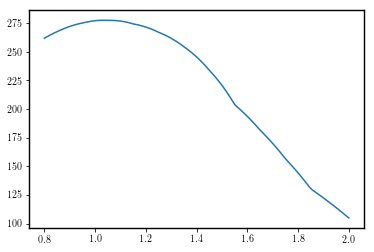

In [30]:
ztab = np.array(np.linspace(0.8, 2.0, 100))
snrtab = np.array([snr_ps(0.001, 0.15*hubble, z-0.1, z, 20.0, 1.0, 10.0) for z in ztab])

plt.plot(ztab, snrtab)
plt.show()

In [31]:
#move on to bispectrum signal to noise ratio

#need beta coefficients

global beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19

#coefficients beta
def set_betas(z, bias):
    Hu, H0, om_m0, om_m, f, df, dHu, ddHu, chi, cap_L, partdQ, gamma1, gamma2, partdb1, fnl, b1, db1, b2, b_e, db_e, Q, dQ = set_params(z, bias)    
    beta1 = Hu**4 * ((9.0/4.0)*om_m**2 * (6- 2*f * (2*b_e - 4*Q - (4*(1-Q))/(chi*Hu) - (2*dHu)/(Hu**2)) - (2*df)/(Hu) + b_e**2 + 5*b_e - 8*b_e*Q + 4*Q + 16*Q**2 - 16*partdQ - 8*dQ/Hu + db_e/Hu + (2/(chi**2 * Hu**2))*(1-Q + 2*Q**2 - 2*partdQ)  - (2/(chi*Hu))*(3+2*b_e - 2*b_e*Q - 3*Q + 8*Q**2 - (3*dHu/Hu**2)*(1-Q) - 8*partdQ - 2*dQ/Hu) + (dHu/Hu**2)*(-7 -2*b_e + 8*Q + (3*dHu/Hu**2)) - (ddHu/Hu**3))  + ((3/2)*om_m * f)*(5 - 2*f*(4-b_e) + (2*df/Hu) + 2*b_e*(5 + ((2*(1-Q))/(chi*Hu))) - (2*db_e/Hu) - 2*b_e**2 + 8*b_e*Q - 28*Q - (14*(1-Q)/(chi*Hu)) - 3*dHu/Hu**2 + 4*(2-(1/(chi*Hu)))*(dQ/Hu) ) + ((3/2)*om_m*f**2)*(-2 + 2*f -b_e + 4*Q + (2*(1-Q)/(chi*Hu)) + (3*dHu/Hu**2) - (12/3)*fnl ) + f**2 * (12-7*b_e + b_e**2 + (db_e/Hu) + (b_e - 3)*(dHu/Hu**2)) - (3/2)*om_m*(df/Hu))
    beta2 = Hu**4* ((9/2)*om_m**2 * (-1 + b_e - 2*Q - ((2*(1-Q))/(chi*Hu)) - (dHu/Hu**2) ) + 3*om_m*f*(-1 + 2*f -b_e + 4*Q + (2*(1-Q)/(chi*Hu)) + (3*dHu/Hu**2) )  + 3*om_m * f**2 * (-1+b_e-2*Q - ((2*(1-Q))/(chi*Hu)) - (dHu/Hu**2))  + 3*om_m*(df/Hu))
    beta3 = Hu**3 * ((9/4)*om_m**2 *(f-2+2*Q) + (3/2)*om_m*f * (-2 -f*(-3 + f + 2*b_e - 3*Q - ((4*(1-Q))/(chi*Hu)) - (2*dHu/Hu**2)) - (df/Hu) + 3*b_e + b_e**2 - 6*b_e*Q + 4*Q + 8*Q**2 - 8*partdQ - 6*(dQ/Hu) + (db_e/Hu) + (2/(chi**2*Hu**2))*(1-Q +2*Q**2 - 2*partdQ) + (2/(chi*Hu))*(-1 -2*b_e + 2*b_e*Q + Q - 6*Q**2 + (3*dHu/Hu**2)*(1-Q) + 6*partdQ + 2*(dQ/Hu) ) - (dHu/Hu**2)*(3+2*b_e - 6*Q - (3*dHu/Hu**2)) - (ddHu/Hu**3))  + f**2 * (-3 + 2*b_e*(2+ ((1-Q)/(chi*Hu))) - b_e**2 + 2*b_e*Q - 6*Q - (db_e/Hu) - ((6*(1-Q))/(chi*Hu)) + 2*(1-(1/(chi*Hu)))*(dQ/Hu) ))
    beta4 = (Hu**3 * ((9/2)*om_m*f * (-b_e + 2*Q +  (2*(1-Q)/(chi*Hu)) + (dHu/Hu**2))))
    beta5 = (Hu**3 * ( 3* om_m * f * (b_e - 2*Q -(2*(1-Q)/(chi*Hu)) - (dHu/Hu**2))  ))
    beta6 = Hu**2 * ((3/2) *om_m * (2-2*f + b_e - 4*Q - ((2*(1-Q))/(chi*Hu)) - (dHu/Hu**2)))
    beta7 = Hu**2*(f*(3-b_e))
    beta8= Hu**2*(3*om_m*f*(2-f-2*Q) + f**2 * (4 + b_e - b_e**2 + 4*b_e*Q - 6*Q - 4*Q**2 + 4*partdQ + 4*(dQ/Hu) -(db_e/Hu) - (2/(chi**2 * Hu**2))*(1-Q+2*Q**2 - 2*partdQ) - (2/(chi*Hu))*(3-2*b_e + 2*b_e*Q - Q - 4*Q**2 + ((3*dHu)/(Hu**2))*(1-Q) + 4*partdQ + 2*(dQ/Hu)) - (dHu/Hu**2)*(3-2*b_e+4*Q+((3*dHu)/(Hu**2))) + (ddHu/Hu**3)))
    beta9 = (Hu**2 * ( -(9/2)*om_m*f ))
    beta10 = (Hu**2 * (3 * om_m * f))
    beta11 = Hu**2 * (3*om_m*(1+f) + 2*f - f**2*(-1+b_e-2*Q - ((2*(1+Q))/(chi*Hu)) - (dHu/Hu**2)))
    beta12 = Hu**2*((3/2)*om_m * (-2 + b1 * (2+b_e-4*Q - ((2*(1-Q))/(chi*Hu)) - (dHu/Hu**2)) + (db1/Hu) + 2*(2-(1/(chi*Hu)))*partdb1) - f*(2+ b1*(f-3+b_e) + (db1/Hu)))
    beta13 = ( (9.0/4.0)*om_m**2.0*Hu**2.0 )+ ( 1.5*om_m*f*Hu**2.0*(-(2.0*f)+(2.0*b_e)-(6.0*Q) -((4.0*(1.0-Q))/(chi*Hu)) -((3.0*dHu)/Hu**2.0) ) )+ ( f**2.0*Hu**2.0*(5.0-b_e) )
    beta14 = Hu* ( -(3/2)*om_m*b1 )
    beta15 = Hu*2*f**2 
    beta16 = Hu*(f*(b1 * (f+b_e-2*Q - ((2*(1-Q))/(chi*Hu)) - (dHu/Hu**2)) + (db1/Hu) + 2*(1- (1/(chi*Hu)))*partdb1 ))
    beta17 = Hu*(-(3/2)*om_m*f)
    beta18 = Hu* ( (3/2)*om_m*f - f**2 * (3 - 2*b_e + 4*Q + ((4*(1-Q))/(chi*Hu)) + (3*dHu/Hu**2)) )
    beta19 = Hu * (f* (b_e - 2*Q - ((2*(1-Q))/(chi*Hu)) - (dHu/Hu**2)))
    return beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19

In [32]:
def get_k3(k1,k2,theta):
    """
        Function to calculate the third k vector given the other two and the angle between them. 
        Assumes vectors form a closed tringle.
    """
    return abs( 
                math.sqrt(
                        (2.0 * math.cos(theta) * ( k1 * k2 ) ) + 
                        k1**2 + k2**2)
                )

def get_theta(k1,k2,k3):
    return np.arccos(0.5 * ( (k3**2 - k1**2 - k2**2) / (k1*k2) ) )

def get_angle_between(i,j,l,k1,k2,theta):
    k3=triangle(k1,k2,theta)
    costheta12 = (0.5 * ((k3**2 - k1**2 - k2**2) / (k1 * k2)))
    costheta13 = (0.5 * ((k2**2 - k1**2 - k3**2) / (k1 * k3)))
    costheta23 = (0.5 * ((k1**2 - k1**2 - k3**2) / (k2 * k3)))
    if i==1 and j==2:
        return costheta12
    elif i==2 and j==1:
        return costheta12
    elif i==1 and j==3:
        return costheta13
    elif i==3 and j==1:
        return costheta13
    elif i==2 and j==3:
        return costheta23
    elif i==3 and j==2:
        return costheta23
    else:
        return 0

In [26]:
a_vals = np.loadtxt("avalues.txt")
b_vals = np.loadtxt("bvalues.txt")
coeff_vals= ["(42*angleFunction(1,2,3,k1,k2,theta)*beta2*gamma2**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta2*gamma2*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) + 63*beta2*gamma2**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*beta2*gamma2**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 63*b1*beta2*gamma2*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta2*gamma2*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta2*gamma2**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta2*gamma2*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta2*k1**5*k2**3*Pmz(k1,z)*Pmz(k2,z) + 63*b1*beta2*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta2*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) + 63*b1**2*beta2*k1**4*k2**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*b1**2*beta2*k1**4*k2**4*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta2*gamma2*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta2*k1**3*k2**5*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta6*gamma2**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta7*gamma2**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta6*gamma2*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta7*gamma2*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 30*beta6*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*beta6*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*beta7*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*beta7*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 30*b1*beta6*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta6*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*b1*beta7*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta7*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta6*gamma2**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta7*gamma2**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta6*gamma2*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta7*gamma2*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta6*k1**5*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta7*k1**5*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 30*b1*beta6*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta6*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*b1*beta7*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta7*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 30*b1**2*beta6*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*b1**2*beta6*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*b1**2*beta7*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*b1**2*beta7*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta6*gamma2*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta7*gamma2*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta6*k1**3*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta7*k1**3*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*beta1*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta1*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta12*gamma2**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta12*gamma2*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta11*gamma2**2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta11*gamma2*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*gamma2**2*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*gamma2*k1**5*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta1*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta12*gamma2**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1**2*beta1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*b1*beta12*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 4*gamma2**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*gamma2**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 34*b1*gamma2**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b2*gamma2**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1**2*beta12*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 4*b1*gamma2*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*b1*gamma2*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 34*b1**2*gamma2*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*b2*gamma2*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta11*gamma2*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*gamma2**2*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta11*k1**3*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1**2*gamma2*k1**3*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**3*k1**5*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta12*gamma2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1**2*beta12*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 4*b1*gamma2*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*b1*gamma2*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 34*b1**2*gamma2*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*b2*gamma2*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 4*b1**2*k1**4*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*b1**2*k1**4*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 34*b1**3*k1**4*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1**2*b2*k1**4*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*gamma2*k1*k2**5*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**3*k1**3*k2**5*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta1*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta1*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta12*gamma2**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta12*gamma2*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta2*gamma2**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta2*gamma2*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta6*gamma2**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta7*gamma2**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta6*gamma2*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta7*gamma2*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta11*gamma2**2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta11*gamma2*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*gamma2**2*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*gamma2*k1**5*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 63*beta2*gamma2**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*beta2*gamma2**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta2*gamma2*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta2*gamma2*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 30*beta6*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 12*angleFunction(1,3,2,k1,k2,theta)**2*beta6*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 18*beta7*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*beta7*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 30*b1*beta6*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta6*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 18*b1*beta7*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta7*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta1*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*beta12*gamma2**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1**2*beta1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*b1*beta12*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 4*gamma2**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 12*angleFunction(1,3,2,k1,k2,theta)**2*gamma2**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 34*b1*gamma2**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b2*gamma2**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1**2*beta12*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 4*b1*gamma2*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*gamma2*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 34*b1**2*gamma2*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*b2*gamma2*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta2*gamma2**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 84*angleFunction(1,3,2,k1,k2,theta)*b1*beta2*gamma2*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1**2*beta2*k1**5*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta6*gamma2**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta7*gamma2**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta6*gamma2*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta7*gamma2*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*beta6*k1**5*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*beta7*k1**5*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta11*gamma2*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*gamma2**2*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*beta11*k1**3*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1**2*gamma2*k1**3*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1**3*k1**5*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta2*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta2*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 63*b1**2*beta2*k1**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*b1**2*beta2*k1**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 30*b1*beta6*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta6*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 18*b1*beta7*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta7*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 30*b1**2*beta6*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 12*angleFunction(1,3,2,k1,k2,theta)**2*b1**2*beta6*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 18*b1**2*beta7*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*b1**2*beta7*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta12*gamma2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1**2*beta12*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 4*b1*gamma2*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*gamma2*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 34*b1**2*gamma2*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*b2*gamma2*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 4*b1**2*k1**4*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 12*angleFunction(1,3,2,k1,k2,theta)**2*b1**2*k1**4*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 34*b1**3*k1**4*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1**2*b2*k1**4*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta2*gamma2*k1*k3**5*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1**2*beta2*k1**3*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta6*gamma2*k1*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta7*gamma2*k1*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*beta6*k1**3*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*beta7*k1**3*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*gamma2*k1*k2**4*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1**3*k1**3*k2**4*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*beta1*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta1*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta12*gamma2**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta12*gamma2*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta11*gamma2**2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta2*gamma2**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta6*gamma2**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta7*gamma2**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta11*gamma2*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*gamma2**2*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta2*gamma2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta6*gamma2*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta7*gamma2*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*gamma2*k1**4*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta1*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta12*gamma2**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*beta2*gamma2**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*beta2*gamma2**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 30*beta6*gamma2**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 12*angleFunction(2,3,1,k1,k2,theta)**2*beta6*gamma2**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 18*beta7*gamma2**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*beta7*gamma2**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1**2*beta1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*b1*beta12*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 4*gamma2**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 12*angleFunction(2,3,1,k1,k2,theta)**2*gamma2**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 34*b1*gamma2**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b2*gamma2**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta2*gamma2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta2*gamma2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 30*b1*beta6*gamma2*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta6*gamma2*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 18*b1*beta7*gamma2*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta7*gamma2*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1**2*beta12*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 4*b1*gamma2*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*gamma2*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 34*b1**2*gamma2*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*b2*gamma2*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta2*gamma2**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta6*gamma2**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta7*gamma2**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta11*gamma2*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*gamma2**2*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 84*angleFunction(2,3,1,k1,k2,theta)*b1*beta2*gamma2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta6*gamma2*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta7*gamma2*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*beta11*k1**4*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1**2*gamma2*k1**4*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1**2*beta2*k2**5*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*beta6*k1**2*k2**5*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*beta7*k1**2*k2**5*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1**3*k1**4*k2**5*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta12*gamma2*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta2*gamma2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta2*gamma2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 30*b1*beta6*gamma2*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta6*gamma2*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 18*b1*beta7*gamma2*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta7*gamma2*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1**2*beta12*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 4*b1*gamma2*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*gamma2*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 34*b1**2*gamma2*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1*b2*gamma2*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 63*b1**2*beta2*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*b1**2*beta2*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 30*b1**2*beta6*k1**2*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 12*angleFunction(2,3,1,k1,k2,theta)**2*b1**2*beta6*k1**2*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 18*b1**2*beta7*k1**2*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*b1**2*beta7*k1**2*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) - 4*b1**2*k1**4*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 12*angleFunction(2,3,1,k1,k2,theta)**2*b1**2*k1**4*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 34*b1**3*k1**4*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1**2*b2*k1**4*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta2*gamma2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta6*gamma2*k1**2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta7*gamma2*k1**2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*gamma2*k1**4*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1**2*beta2*k2**3*k3**5*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*beta6*k1**2*k2**3*k3**5*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*beta7*k1**2*k2**3*k3**5*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1**3*k1**4*k2**3*k3**5*Pmz(k2,z)*Pmz(k3,z))/(21*k1**4*k2**4*k3**4)","(42*angleFunction(1,2,3,k1,k2,theta)*beta2*gamma1*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta5*gamma2**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta2*gamma1*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*gamma2*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) + 63*beta2*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*beta2*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*beta5*gamma2**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*beta5*gamma2**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 63*b1*beta2*gamma1*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta2*gamma1*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta5*gamma2*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta5*gamma2*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta2*gamma1*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta5*gamma2**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta2*gamma1*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*gamma2*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta5*k1**5*k2**3*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta5*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta5*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 63*b1**2*beta5*k1**4*k2**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1**2*beta5*k1**4*k2**4*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*gamma2*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta5*k1**3*k2**5*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta6*gamma1*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta7*gamma1*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta19*gamma2**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta6*gamma1*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta7*gamma1*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*gamma2*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 30*beta6*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*beta6*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*beta7*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*beta7*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*beta19*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*beta19*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 30*b1*beta6*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta6*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*b1*beta7*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta7*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*beta19*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta19*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta6*gamma1*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta7*gamma1*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta19*gamma2**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta6*gamma1*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta7*gamma1*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*gamma2*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta19*k1**5*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*beta19*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta19*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1**2*beta19*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1**2*beta19*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*gamma2*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta19*k1**3*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*beta1*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta3*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta4*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta1*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta3*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta4*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta12*gamma1*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta16*gamma2**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta12*gamma1*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta16*gamma2*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta11*gamma1*gamma2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta15*gamma2**2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta11*gamma1*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta15*gamma2*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*gamma1*gamma2*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*gamma1*k1**5*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta3*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta4*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta12*gamma1*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta14*gamma2**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1**2*beta3*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*beta4*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta12*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta14*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta16*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 4*gamma1*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*gamma1*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 34*b1*gamma1*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b2*gamma1*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1**2*beta16*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 4*b1*gamma1*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*b1*gamma1*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 34*b1**2*gamma1*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*b2*gamma1*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta15*gamma2*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*gamma1*gamma2*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta15*k1**3*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*gamma1*k1**3*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta14*gamma2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1**2*beta14*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta1*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta3*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta4*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta1*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta3*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta4*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta12*gamma1*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta16*gamma2**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta12*gamma1*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta16*gamma2*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta2*gamma1*gamma2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta5*gamma2**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta2*gamma1*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta5*gamma2*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta6*gamma1*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta7*gamma1*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta19*gamma2**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta6*gamma1*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta7*gamma1*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta19*gamma2*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta11*gamma1*gamma2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta15*gamma2**2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta11*gamma1*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta15*gamma2*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*gamma1*gamma2*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*gamma1*k1**5*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 63*beta2*gamma1*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*beta2*gamma1*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*beta5*gamma2**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*beta5*gamma2**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta2*gamma1*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta2*gamma1*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta5*gamma2*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta5*gamma2*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 30*beta6*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*beta6*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*beta7*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*beta7*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 18*beta19*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*beta19*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 30*b1*beta6*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta6*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*b1*beta7*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta7*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 18*b1*beta19*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta19*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta3*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta4*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta12*gamma1*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta14*gamma2**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1**2*beta3*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1**2*beta4*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta12*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta14*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta16*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 4*gamma1*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*gamma1*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 34*b1*gamma1*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b2*gamma1*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1**2*beta16*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 4*b1*gamma1*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*gamma1*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 34*b1**2*gamma1*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*b2*gamma1*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta2*gamma1*gamma2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta5*gamma2**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta2*gamma1*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) + 84*angleFunction(1,3,2,k1,k2,theta)*b1*beta5*gamma2*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1**2*beta5*k1**5*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta6*gamma1*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta7*gamma1*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta19*gamma2**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta6*gamma1*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta7*gamma1*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta19*gamma2*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*beta19*k1**5*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta15*gamma2*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*gamma1*gamma2*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*beta15*k1**3*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*gamma1*k1**3*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta5*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta5*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 63*b1**2*beta5*k1**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*b1**2*beta5*k1**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 18*b1*beta19*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta19*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 18*b1**2*beta19*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*b1**2*beta19*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta14*gamma2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1**2*beta14*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta5*gamma2*k1*k3**5*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1**2*beta5*k1**3*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta19*gamma2*k1*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*beta19*k1**3*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta1*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta14*gamma2**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta16*gamma2**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta12*gamma1*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta14*gamma2*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta16*gamma2*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta11*gamma1*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta2*gamma1*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta6*gamma1*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta7*gamma1*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*gamma1*k1**4*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta1*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta14*gamma2**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta16*gamma2**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta2*gamma1*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta2*gamma1*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 30*b1*beta6*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta6*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*b1*beta7*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta7*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1**2*beta14*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1**2*beta16*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 4*b1*gamma1*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*gamma1*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 34*b1**2*gamma1*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*b2*gamma1*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta11*gamma1*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta12*gamma1*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta14*gamma2*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta16*gamma2*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta2*gamma1*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta2*gamma1*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 30*b1*beta6*gamma1*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta6*gamma1*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 18*b1*beta7*gamma1*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta7*gamma1*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1**2*beta14*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1**2*beta16*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 4*b1*gamma1*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*gamma1*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 34*b1**2*gamma1*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1*b2*gamma1*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta2*gamma1*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta6*gamma1*k1**2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta7*gamma1*k1**2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*gamma1*k1**4*k2*k3**5*Pmz(k2,z)*Pmz(k3,z))/(21*k1**4*k2**3*k3**4)","(-42*angleFunction(1,2,3,k1,k2,theta)*beta2*f*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta5*gamma1*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma2**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta2*f*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*gamma1*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma2*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) - 63*beta2*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*beta2*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*beta5*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*beta5*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*beta10*gamma2**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*beta10*gamma2**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta2*f*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta2*f*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta5*gamma1*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta5*gamma1*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta10*gamma2*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*gamma2*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta2*f*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta5*gamma1*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma2**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta2*f*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*gamma1*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma2*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta10*k1**5*k2**3*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta10*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 63*b1**2*beta10*k1**4*k2**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1**2*beta10*k1**4*k2**4*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma2*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta10*k1**3*k2**5*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta6*f*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta7*f*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta19*gamma1*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*f*gamma2**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta6*f*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta7*f*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*gamma1*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma2*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 30*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 12*angleFunction(1,2,3,k1,k2,theta)**2*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*beta19*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*beta19*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*f*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*f*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 30*b1*beta6*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 12*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta6*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*beta7*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta7*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*beta19*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta19*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*f*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*f*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta6*f*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta7*f*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta19*gamma1*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*f*gamma2**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta6*f*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta7*f*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*gamma1*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma2*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*f*k1**5*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1**2*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1**2*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma2*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*f*k1**3*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*beta1*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta3*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta4*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta13*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta9*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta1*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta3*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta4*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta13*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta9*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta12*f*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta16*gamma1*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*f*gamma2**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta12*f*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta16*gamma1*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*f*gamma2*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta11*f*gamma2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta15*gamma1*gamma2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta11*f*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta15*gamma1*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma2*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*f*k1**5*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta13*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta9*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta12*f*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta14*gamma1*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*beta13*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*beta9*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta12*f*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta14*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 4*f*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 12*angleFunction(1,2,3,k1,k2,theta)**2*f*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 34*b1*f*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*f*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b2*f*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 4*b1*f*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 12*angleFunction(1,2,3,k1,k2,theta)**2*b1*f*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 34*b1**2*f*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**3*f*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*b2*f*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma2*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*f*k1**3*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta1*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta3*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta4*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta13*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta9*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta1*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta3*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta4*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta13*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta9*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta12*f*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta16*gamma1*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*f*gamma2**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta12*f*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta16*gamma1*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1**2*f*gamma2*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta2*f*gamma2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta5*gamma1*gamma2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta10*gamma2**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta2*f*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta5*gamma1*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta10*gamma2*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta6*f*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta7*f*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta19*gamma1*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*f*gamma2**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta6*f*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta7*f*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta19*gamma1*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma2*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta11*f*gamma2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta15*gamma1*gamma2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta11*f*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta15*gamma1*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma2*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*f*k1**5*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 63*beta2*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*beta2*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 63*beta5*gamma1*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*beta5*gamma1*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 63*beta10*gamma2**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*beta10*gamma2**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta2*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta2*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta5*gamma1*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta5*gamma1*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta10*gamma2*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta10*gamma2*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 30*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*beta19*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*beta19*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*f*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*f*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 30*b1*beta6*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta6*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*b1*beta7*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta7*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*b1*beta19*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta19*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*b1*f*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*f*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta13*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta9*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta12*f*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*beta14*gamma1*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1**2*beta13*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1**2*beta9*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta12*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta14*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 4*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 34*b1*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1**2*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b2*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 4*b1*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 34*b1**2*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1**3*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*b2*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta2*f*gamma2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta5*gamma1*gamma2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta10*gamma2**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta2*f*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta5*gamma1*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*b1*beta10*gamma2*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1**2*beta10*k1**5*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta6*f*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta7*f*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta19*gamma1*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*f*gamma2**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta6*f*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta7*f*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta19*gamma1*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma2*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*f*k1**5*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma2*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*f*k1**3*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta10*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta10*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 63*b1**2*beta10*k1**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*b1**2*beta10*k1**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 18*b1*f*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*f*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 18*b1**2*f*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1**2*f*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta10*gamma2*k1*k3**5*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1**2*beta10*k1**3*k3**5*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma2*k1*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*f*k1**3*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) - 21*beta1*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 42*beta1*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 42*beta13*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta8*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta1*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta12*gamma1**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*beta13*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta8*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 42*beta12*f*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta12*f*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta14*gamma1*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta16*gamma1*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta11*gamma1**2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta11*f*gamma2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta2*gamma1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*beta2*f*gamma2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta6*gamma1**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta7*gamma1**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta6*f*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta7*f*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta11*f*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*gamma1**2*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma2*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta2*f*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta6*f*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta7*f*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*f*k1**4*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta1*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta12*gamma1**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*beta13*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta8*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*beta12*f*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*beta2*gamma1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*beta2*gamma1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 126*beta2*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)**2*beta2*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 30*beta6*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*beta6*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*beta7*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*beta7*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 60*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 36*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 48*angleFunction(2,3,1,k1,k2,theta)**2*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1**2*beta13*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1**2*beta8*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*beta12*f*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*b1*beta14*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*beta16*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 4*gamma1**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*gamma1**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 34*b1*gamma1**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b2*gamma1**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 8*f*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*f*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 68*b1*f*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b2*f*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta2*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta2*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 30*b1*beta6*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta6*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*b1*beta7*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta7*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 4*b1*f*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*f*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 34*b1**2*f*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*b2*f*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta2*gamma1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*beta2*f*gamma2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta6*gamma1**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta7*gamma1**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta6*f*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta7*f*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta11*f*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*gamma1**2*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma2*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*b1*beta2*f*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta6*f*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta7*f*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1**2*f*k1**4*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta12*f*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta14*gamma1*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta16*gamma1*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta2*f*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta2*f*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 30*b1*beta6*f*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta6*f*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 18*b1*beta7*f*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta7*f*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 4*b1*f*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*f*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 34*b1**2*f*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1*b2*f*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta2*f*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta6*f*k1**2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta7*f*k1**2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*f*k1**4*k2*k3**5*Pmz(k2,z)*Pmz(k3,z))/(21*k1**4*k2**2*k3**4)","(14*angleFunction(1,2,3,k1,k2,theta)*beta5*f*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 14*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma1*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 14*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*f*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) - 14*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma1*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) + 21*beta5*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)**2*beta5*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*beta10*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)**2*beta10*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta5*f*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta5*f*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta10*gamma1*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*gamma1*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 14*angleFunction(1,2,3,k1,k2,theta)*beta5*f*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 14*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma1*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 14*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*f*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 14*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma1*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*beta19*f*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*f*gamma1*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*f*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma1*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 6*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 8*angleFunction(1,2,3,k1,k2,theta)**2*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 6*f*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 8*angleFunction(1,2,3,k1,k2,theta)**2*f*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 6*b1*beta19*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 8*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta19*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 6*b1*f*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 8*angleFunction(1,2,3,k1,k2,theta)**2*b1*f*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*beta19*f*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*f*gamma1*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*f*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma1*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 7*beta3*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta4*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta13*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta9*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta17*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*beta3*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*b1*beta4*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*beta13*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*beta9*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*beta17*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta16*f*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*f*gamma1*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*beta16*f*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1**2*f*gamma1*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*beta15*f*gamma2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*b1*beta15*f*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*beta17*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta14*f*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1**2*beta17*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*beta14*f*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta3*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 7*beta4*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta13*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta9*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta17*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*b1*beta3*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 7*b1*beta4*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*b1*beta13*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*b1*beta9*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*b1*beta17*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta16*f*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*b1*f*gamma1*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*b1*beta16*f*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*b1**2*f*gamma1*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 14*angleFunction(1,3,2,k1,k2,theta)*beta5*f*gamma2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta10*gamma1*gamma2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 14*angleFunction(1,3,2,k1,k2,theta)*b1*beta5*f*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*b1*beta10*gamma1*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) - 7*angleFunction(1,3,2,k1,k2,theta)*beta19*f*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*f*gamma1*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 7*angleFunction(1,3,2,k1,k2,theta)*b1*beta19*f*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma1*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*beta15*f*gamma2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*b1*beta15*f*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*beta5*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 7*angleFunction(1,3,2,k1,k2,theta)**2*beta5*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*beta10*gamma1*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)**2*beta10*gamma1*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta5*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 7*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta5*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta10*gamma1*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta10*gamma1*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 6*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 8*angleFunction(1,3,2,k1,k2,theta)**2*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 6*f*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 8*angleFunction(1,3,2,k1,k2,theta)**2*f*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 6*b1*beta19*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 8*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta19*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 6*b1*f*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 8*angleFunction(1,3,2,k1,k2,theta)**2*b1*f*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*b1*beta17*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*beta14*f*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*b1**2*beta17*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*b1*beta14*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 14*angleFunction(1,3,2,k1,k2,theta)*beta5*f*gamma2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta10*gamma1*gamma2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 14*angleFunction(1,3,2,k1,k2,theta)*b1*beta5*f*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*b1*beta10*gamma1*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) - 7*angleFunction(1,3,2,k1,k2,theta)*beta19*f*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*f*gamma1*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 7*angleFunction(1,3,2,k1,k2,theta)*b1*beta19*f*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma1*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 14*b1*beta13*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 7*b1*beta8*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 7*beta14*gamma1**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 7*beta16*gamma1**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 14*beta14*f*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 14*beta16*f*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 7*b1*beta14*f*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 7*b1*beta16*f*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) - 14*b1*beta13*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*b1*beta8*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*beta14*gamma1**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 7*beta16*gamma1**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 14*beta14*f*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 14*beta16*f*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*b1*beta14*f*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z) - 7*b1*beta16*f*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z))/(7*k1**4*k2*k3**4)","(42*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*f*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) + 63*beta10*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*beta10*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 63*b1*beta10*f*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*f*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*f*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*f**2*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*b1*f**2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*f**2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*f**2*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*beta13*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta9*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta17*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta13*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta9*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta17*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*f**2*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1**2*f**2*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta13*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta9*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta17*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta13*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta9*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta17*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*f**2*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1**2*f**2*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta10*f*gamma2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta10*f*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*f**2*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*f**2*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 63*beta10*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*beta10*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta10*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta10*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 18*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 18*b1*f**2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*f**2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta10*f*gamma2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta10*f*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*f**2*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*f**2*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*beta1*f**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 42*beta13*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta8*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 84*beta13*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 42*beta8*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 42*b1*beta13*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta8*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta12*f**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta11*f**2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta2*f**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta6*f**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta7*f**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*f**2*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 42*b1*beta13*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta8*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta12*f**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*beta2*f**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*beta2*f**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 30*beta6*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 12*angleFunction(2,3,1,k1,k2,theta)**2*beta6*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 18*beta7*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*beta7*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 4*f**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 12*angleFunction(2,3,1,k1,k2,theta)**2*f**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 34*b1*f**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b2*f**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta2*f**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta6*f**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta7*f**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*f**2*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z))/(21*k1**4*k3**4)","(f*k2*(beta17*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + b1*beta17*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - beta17*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - b1*beta17*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + beta14*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - beta16*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - beta14*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + beta16*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z)))/(k1**4*k3**4)","(-2*beta13*f**2*k2**2*Pmz(k2,z)*Pmz(k3,z) + beta8*f**2*k2**2*Pmz(k2,z)*Pmz(k3,z))/k3**4","(42*angleFunction(1,2,3,k1,k2,theta)*beta2*gamma1*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta5*gamma2**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*gamma2*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) + 63*beta2*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*beta2*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*beta5*gamma2**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*beta5*gamma2**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta5*gamma2*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta5*gamma2*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta2*gamma1*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta5*gamma2**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta2*gamma1*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*gamma2*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta5*k1**5*k2**3*Pmz(k1,z)*Pmz(k2,z) + 63*b1*beta2*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta2*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta5*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta5*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 63*b1**2*beta5*k1**4*k2**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1**2*beta5*k1**4*k2**4*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta2*gamma1*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*gamma2*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta5*k1**3*k2**5*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta6*gamma1*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta7*gamma1*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta19*gamma2**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*gamma2*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 30*beta6*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*beta6*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*beta7*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*beta7*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*beta19*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*beta19*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*beta19*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta19*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta6*gamma1*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta7*gamma1*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta19*gamma2**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta6*gamma1*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta7*gamma1*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*gamma2*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta19*k1**5*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 30*b1*beta6*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta6*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*b1*beta7*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta7*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*beta19*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta19*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1**2*beta19*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1**2*beta19*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta6*gamma1*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta7*gamma1*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*gamma2*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta19*k1**3*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*beta1*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta3*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta4*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta3*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta4*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta12*gamma1*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta14*gamma2**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta14*gamma2*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta11*gamma1*gamma2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta15*gamma2**2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta15*gamma2*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*gamma1*gamma2*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta1*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta3*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta4*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta12*gamma1*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta16*gamma2**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1**2*beta3*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*beta4*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta12*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta14*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta16*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 4*gamma1*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*gamma1*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 34*b1*gamma1*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b2*gamma1*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1**2*beta14*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta11*gamma1*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta15*gamma2*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*gamma1*gamma2*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta15*k1**3*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*gamma1*k1**3*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta12*gamma1*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta16*gamma2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1**2*beta16*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 4*b1*gamma1*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*b1*gamma1*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 34*b1**2*gamma1*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*b2*gamma1*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*gamma1*k1*k2**5*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta1*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta14*gamma2**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta16*gamma2**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta12*gamma1*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta14*gamma2*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta16*gamma2*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta2*gamma1*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta6*gamma1*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta7*gamma1*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta11*gamma1*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*gamma1*k1**5*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta2*gamma1*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta2*gamma1*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 30*b1*beta6*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta6*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*b1*beta7*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta7*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta1*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta14*gamma2**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*beta16*gamma2**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1**2*beta14*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1**2*beta16*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 4*b1*gamma1*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*gamma1*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 34*b1**2*gamma1*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*b2*gamma1*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta11*gamma1*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta2*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta2*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 30*b1*beta6*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta6*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 18*b1*beta7*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta7*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta12*gamma1*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta14*gamma2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta16*gamma2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1**2*beta14*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1**2*beta16*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 4*b1*gamma1*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*gamma1*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 34*b1**2*gamma1*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*b2*gamma1*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta2*gamma1*k1*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta6*gamma1*k1*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta7*gamma1*k1*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*gamma1*k1*k2**4*k3**5*Pmz(k1,z)*Pmz(k3,z) - 21*beta1*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta3*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta4*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta1*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta3*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta4*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta12*gamma1*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta16*gamma2**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta12*gamma1*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta16*gamma2*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta11*gamma1*gamma2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta15*gamma2**2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta2*gamma1*gamma2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta5*gamma2**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta6*gamma1*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta7*gamma1*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta19*gamma2**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta11*gamma1*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta15*gamma2*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*gamma1*gamma2*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta2*gamma1*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta5*gamma2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta6*gamma1*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta7*gamma1*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta19*gamma2*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*gamma1*k1**4*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta3*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta4*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta12*gamma1*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta14*gamma2**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*beta2*gamma1*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*beta2*gamma1*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*beta5*gamma2**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*beta5*gamma2**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 30*beta6*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*beta6*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*beta7*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*beta7*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 18*beta19*gamma2**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*beta19*gamma2**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1**2*beta3*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1**2*beta4*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta12*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta14*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta16*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 4*gamma1*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*gamma1*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 34*b1*gamma1*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b2*gamma1*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta2*gamma1*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta2*gamma1*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta5*gamma2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta5*gamma2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 30*b1*beta6*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta6*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*b1*beta7*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta7*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 18*b1*beta19*gamma2*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta19*gamma2*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1**2*beta16*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 4*b1*gamma1*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*gamma1*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 34*b1**2*gamma1*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*b2*gamma1*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta2*gamma1*gamma2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta5*gamma2**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta6*gamma1*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta7*gamma1*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta19*gamma2**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta15*gamma2*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*gamma1*gamma2*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta2*gamma1*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 84*angleFunction(2,3,1,k1,k2,theta)*b1*beta5*gamma2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta6*gamma1*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta7*gamma1*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta19*gamma2*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*beta15*k1**4*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*gamma1*k1**4*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1**2*beta5*k2**5*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*beta19*k1**2*k2**5*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta14*gamma2*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta5*gamma2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta5*gamma2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 18*b1*beta19*gamma2*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta19*gamma2*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1**2*beta14*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 63*b1**2*beta5*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*b1**2*beta5*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 18*b1**2*beta19*k1**2*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*b1**2*beta19*k1**2*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta5*gamma2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta19*gamma2*k1**2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1**2*beta5*k2**3*k3**5*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*beta19*k1**2*k2**3*k3**5*Pmz(k2,z)*Pmz(k3,z))/(21*k1**3*k2**4*k3**4)","(42*angleFunction(1,2,3,k1,k2,theta)*beta2*gamma1**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*beta5*gamma1*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma2**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*gamma1*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma2*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) + 63*beta2*gamma1**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*beta2*gamma1**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 126*beta5*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)**2*beta5*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 126*beta10*gamma2**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)**2*beta10*gamma2**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta5*gamma1*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta5*gamma1*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 126*b1*beta10*gamma2*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*gamma2*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta2*gamma1**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*beta5*gamma1*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma2**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*gamma1*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 168*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma2*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta10*k1**5*k2**3*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta5*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta5*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 126*b1*beta10*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 126*b1**2*beta10*k1**4*k2**4*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)**2*b1**2*beta10*k1**4*k2**4*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*gamma1*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma2*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta10*k1**3*k2**5*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta6*gamma1**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta7*gamma1**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta19*gamma1*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*f*gamma2**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*gamma1*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma2*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 30*beta6*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*beta6*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*beta7*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*beta7*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 36*beta19*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 48*angleFunction(1,2,3,k1,k2,theta)**2*beta19*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 36*f*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 48*angleFunction(1,2,3,k1,k2,theta)**2*f*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*beta19*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta19*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 36*b1*f*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 48*angleFunction(1,2,3,k1,k2,theta)**2*b1*f*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta6*gamma1**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta7*gamma1**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta19*gamma1*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*f*gamma2**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*gamma1*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma2*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1**2*f*k1**5*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*beta19*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta19*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 36*b1*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 48*angleFunction(1,2,3,k1,k2,theta)**2*b1*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 36*b1**2*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 48*angleFunction(1,2,3,k1,k2,theta)**2*b1**2*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*gamma1*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma2*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1**2*f*k1**3*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*beta1*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*beta3*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*beta4*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta8*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*beta9*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta3*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta4*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta12*gamma1**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta8*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*b1*beta9*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta14*gamma1*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta16*gamma1*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*f*gamma2**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta14*gamma1*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*f*gamma2*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta11*gamma1**2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta15*gamma1*gamma2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta15*gamma1*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*gamma1**2*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta3*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta4*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta12*gamma1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta8*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*b1*beta9*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta14*gamma1*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta16*gamma1*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*f*gamma2**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*beta8*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*b1**2*beta9*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*b1*beta16*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 4*gamma1**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*gamma1**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 34*b1*gamma1**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b2*gamma1**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*b1**2*f*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**3*f*k1**4*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta15*gamma1*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*gamma1**2*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta14*gamma1*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*f*gamma2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**3*f*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta1*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*beta1*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*beta13*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta8*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*b1*beta1*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta3*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta4*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta12*gamma1**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*b1*beta13*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta8*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*beta12*f*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta14*gamma1*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta16*gamma1*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*f*gamma2**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*b1*beta12*f*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta14*gamma1*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*b1*beta16*gamma1*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1**2*f*gamma2*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta2*gamma1**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*beta2*f*gamma2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*b1*beta2*f*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta5*gamma1*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta6*gamma1**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta7*gamma1**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta6*f*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta7*f*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta6*f*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta7*f*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta19*gamma1*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta11*gamma1**2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta11*f*gamma2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta11*f*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta15*gamma1*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*gamma1**2*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma2*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1**2*f*k1**5*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 63*beta2*gamma1**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*beta2*gamma1**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 126*beta2*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)**2*beta2*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 126*b1*beta2*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta2*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta5*gamma1*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta5*gamma1*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 30*beta6*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*beta6*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*beta7*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*beta7*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 60*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 36*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 48*angleFunction(1,3,2,k1,k2,theta)**2*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 60*b1*beta6*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta6*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 36*b1*beta7*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 48*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta7*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*b1*beta19*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta19*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta3*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta4*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta12*gamma1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1*beta13*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta8*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*beta12*f*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*beta14*gamma1*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta16*gamma1*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*f*gamma2**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1**2*beta13*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1**2*beta8*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1*beta12*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*b1*beta14*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1*beta16*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 4*gamma1**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*gamma1**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 34*b1*gamma1**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b2*gamma1**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 8*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 68*b1*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b2*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 8*b1*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 68*b1**2*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1**3*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1*b2*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta2*gamma1**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*beta2*f*gamma2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*b1*beta2*f*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta6*gamma1**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta7*gamma1**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta6*f*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta7*f*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta6*f*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta7*f*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta15*gamma1*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*gamma1**2*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma2*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1**2*f*k1**3*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta5*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta5*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 18*b1*beta19*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta19*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta14*gamma1*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1**2*f*gamma2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1**3*f*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta5*gamma1*k1*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta19*gamma1*k1*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) - 21*beta1*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 42*beta1*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 42*beta13*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta8*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 42*b1*beta1*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta3*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta4*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta12*gamma1**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*beta13*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta8*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 42*beta12*f*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta14*gamma1*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta16*gamma1*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*f*gamma2**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*beta12*f*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta14*gamma1*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 42*b1*beta16*gamma1*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1**2*f*gamma2*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta11*gamma1**2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta11*f*gamma2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta2*gamma1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*beta2*f*gamma2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta6*gamma1**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta7*gamma1**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta6*f*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta7*f*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta11*f*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta15*gamma1*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*gamma1**2*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma2*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*b1*beta2*f*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta5*gamma1*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta6*f*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta7*f*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta19*gamma1*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1**2*f*k1**4*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta3*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta4*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta12*gamma1**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*beta13*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta8*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*beta12*f*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta14*gamma1*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta16*gamma1*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*f*gamma2**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*beta2*gamma1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*beta2*gamma1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 126*beta2*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)**2*beta2*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 30*beta6*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*beta6*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*beta7*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*beta7*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 60*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 36*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 48*angleFunction(2,3,1,k1,k2,theta)**2*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1**2*beta13*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1**2*beta8*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*beta12*f*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*b1*beta14*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*beta16*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 4*gamma1**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*gamma1**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 34*b1*gamma1**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b2*gamma1**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 8*f*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*f*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 68*b1*f*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b2*f*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 126*b1*beta2*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta2*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta5*gamma1*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta5*gamma1*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 60*b1*beta6*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta6*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 36*b1*beta7*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 48*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta7*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*b1*beta19*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta19*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 8*b1*f*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*f*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 68*b1**2*f*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1**3*f*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*b2*f*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta2*gamma1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*beta2*f*gamma2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta6*gamma1**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta7*gamma1**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta6*f*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta7*f*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta15*gamma1*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*gamma1**2*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma2*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*b1*beta2*f*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta6*f*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta7*f*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1**2*f*k1**4*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta14*gamma1*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1**2*f*gamma2*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta5*gamma1*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta5*gamma1*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 18*b1*beta19*gamma1*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta19*gamma1*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1**3*f*k1**4*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta5*gamma1*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta19*gamma1*k1**2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z))/(21*k1**3*k2**3*k3**4)","(-42*angleFunction(1,2,3,k1,k2,theta)*beta2*f*gamma1*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta5*gamma1**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta5*f*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 126*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma1*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*f*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma1*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) - 63*beta2*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*beta2*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*beta5*gamma1**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*beta5*gamma1**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 63*beta5*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*beta5*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 189*beta10*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*angleFunction(1,2,3,k1,k2,theta)**2*beta10*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 63*b1*beta5*f*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta5*f*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 126*b1*beta10*gamma1*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*gamma1*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta2*f*gamma1*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta5*gamma1**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta5*f*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 126*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma1*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*f*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 126*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma1*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta10*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma1*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta6*f*gamma1*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta7*f*gamma1*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta19*gamma1**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta19*f*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 63*angleFunction(1,2,3,k1,k2,theta)*f*gamma1*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*f*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma1*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 30*beta6*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 12*angleFunction(1,2,3,k1,k2,theta)**2*beta6*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*beta7*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*beta7*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*beta19*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*beta19*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 54*f*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 72*angleFunction(1,2,3,k1,k2,theta)**2*f*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*b1*beta19*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta19*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 36*b1*f*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 48*angleFunction(1,2,3,k1,k2,theta)**2*b1*f*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta6*f*gamma1*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta7*f*gamma1*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta19*gamma1**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta19*f*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 63*angleFunction(1,2,3,k1,k2,theta)*f*gamma1*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*f*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 63*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma1*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma1*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*beta1*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta3*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta4*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta3*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta4*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta13*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta8*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 63*beta9*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta18*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta3*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta4*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta8*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*b1*beta9*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta12*f*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta16*gamma1**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta18*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta14*f*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*b1*f*gamma1*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta14*f*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*f*gamma1*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta11*f*gamma1*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta15*gamma1**2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta15*f*gamma2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta15*f*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma1*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta13*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta9*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta12*f*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta14*gamma1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta18*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta16*f*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*f*gamma1*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*beta18*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta16*f*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 4*f*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 12*angleFunction(1,2,3,k1,k2,theta)**2*f*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 34*b1*f*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*b1**2*f*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b2*f*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma1*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta1*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta3*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta4*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*beta3*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*beta4*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*beta13*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta8*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 63*beta17*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta18*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*b1*beta3*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*b1*beta4*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta13*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta8*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta9*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta12*f*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta16*gamma1**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta17*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta18*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta14*f*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 63*beta16*f*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*f*gamma1*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta14*f*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta16*f*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*b1**2*f*gamma1*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta2*f*gamma1*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta5*gamma1**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*beta5*f*gamma2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*b1*beta5*f*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta10*gamma1*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta6*f*gamma1*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta7*f*gamma1*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta19*gamma1**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta19*f*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta19*f*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma1*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta11*f*gamma1*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta15*gamma1**2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta15*f*gamma2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta15*f*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma1*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 63*beta2*f*gamma1*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*beta2*f*gamma1*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 63*beta5*gamma1**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*beta5*gamma1**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 126*beta5*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)**2*beta5*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 126*b1*beta5*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta5*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta10*gamma1*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta10*gamma1*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 30*beta6*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*beta6*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*beta7*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*beta7*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*beta19*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*beta19*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 36*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 48*angleFunction(1,3,2,k1,k2,theta)**2*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 36*b1*beta19*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 48*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta19*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 18*b1*f*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*f*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta13*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta9*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta12*f*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*beta14*gamma1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta17*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta18*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*beta14*f*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta16*f*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*f*gamma1*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*b1**2*beta17*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1**2*beta18*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta14*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta16*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 4*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 34*b1*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1**2*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b2*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta2*f*gamma1*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta5*gamma1**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*beta5*f*gamma2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*b1*beta5*f*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta6*f*gamma1*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta7*f*gamma1*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta19*gamma1**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta19*f*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta19*f*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma1*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta10*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta10*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 18*b1*f*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*f*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta10*gamma1*k1*k3**5*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma1*k1*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) - 21*beta1*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta3*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta4*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 42*beta3*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 42*beta4*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 42*beta13*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta8*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 63*beta17*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta18*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta3*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta4*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 84*b1*beta13*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*beta8*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta12*f*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta14*gamma1**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 42*beta16*gamma1**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta17*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta18*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 42*beta14*f*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 84*beta16*f*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*beta14*f*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta16*f*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1**2*f*gamma1*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta11*f*gamma1*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta15*gamma1**2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta15*f*gamma2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta2*f*gamma1*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta5*gamma1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*beta5*f*gamma2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta6*f*gamma1*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta7*f*gamma1*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta19*gamma1**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta19*f*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta15*f*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma1*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta5*f*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta19*f*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta3*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta4*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*beta13*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta8*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta12*f*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*beta14*gamma1**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta16*gamma1**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta17*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta18*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 84*beta14*f*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*beta16*f*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*beta2*f*gamma1*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*beta2*f*gamma1*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*beta5*gamma1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*beta5*gamma1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 126*beta5*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)**2*beta5*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 30*beta6*f*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*beta6*f*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*beta7*f*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*beta7*f*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*beta19*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*beta19*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 36*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 48*angleFunction(2,3,1,k1,k2,theta)**2*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1**2*beta17*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1**2*beta18*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta14*f*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta16*f*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 4*f*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*f*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 34*b1*f*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1**2*f*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b2*f*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta5*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta5*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*b1*beta19*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta19*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta2*f*gamma1*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta5*gamma1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*beta5*f*gamma2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta6*f*gamma1*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta7*f*gamma1*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta19*gamma1**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta19*f*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta15*f*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma1*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*b1*beta5*f*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta19*f*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta14*f*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1**2*f*gamma1*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta5*f*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta5*f*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 18*b1*beta19*f*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta19*f*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta5*f*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta19*f*k1**2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z))/(21*k1**3*k2**2*k3**4)","(42*angleFunction(1,2,3,k1,k2,theta)*beta5*f*gamma1*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma1**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 84*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*f*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) + 63*beta5*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*beta5*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*beta10*gamma1**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*beta10*gamma1**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 126*beta10*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)**2*beta10*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 126*b1*beta10*f*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*f*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta5*f*gamma1*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma1**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 84*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*f*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta19*f*gamma1*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*f*gamma1**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*f**2*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*beta19*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*beta19*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*f*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*f*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 36*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 48*angleFunction(1,2,3,k1,k2,theta)**2*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 36*b1*f**2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 48*angleFunction(1,2,3,k1,k2,theta)**2*b1*f**2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta19*f*gamma1*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*f*gamma1**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*f**2*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*beta3*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta4*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta13*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta9*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta8*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*beta9*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta17*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta18*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*f**2*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta8*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*b1*beta9*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta18*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta16*f*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*f*gamma1**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*b1*f**2*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1**2*f**2*k1**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta15*f*gamma1*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta17*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta14*f*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*b1*f**2*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*b1**2*f**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta3*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta4*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta13*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta9*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 84*beta13*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta8*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*beta9*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 63*beta17*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta18*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*f**2*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 84*b1*beta13*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta8*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*b1*beta9*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 84*b1*beta17*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta18*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta16*f*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*f*gamma1**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*b1*f**2*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 63*b1**2*f**2*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta5*f*gamma1*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta10*gamma1**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 84*angleFunction(1,3,2,k1,k2,theta)*beta10*f*gamma2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 84*angleFunction(1,3,2,k1,k2,theta)*b1*beta10*f*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta19*f*gamma1*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*f*gamma1**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*f**2*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*f**2*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta15*f*gamma1*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 63*beta5*f*gamma1*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*beta5*f*gamma1*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*beta10*gamma1**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*beta10*gamma1**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 126*beta10*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)**2*beta10*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 126*b1*beta10*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta10*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*beta19*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*beta19*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 18*f*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*f*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 36*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 48*angleFunction(1,3,2,k1,k2,theta)**2*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 36*b1*f**2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 48*angleFunction(1,3,2,k1,k2,theta)**2*b1*f**2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta17*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*beta14*f*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1*f**2*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1**2*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta5*f*gamma1*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta10*gamma1**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 84*angleFunction(1,3,2,k1,k2,theta)*beta10*f*gamma2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 84*angleFunction(1,3,2,k1,k2,theta)*b1*beta10*f*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta19*f*gamma1*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*f*gamma1**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*f**2*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*f**2*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*beta1*f**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 84*beta13*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 42*beta8*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 168*beta13*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 84*beta8*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 126*b1*beta13*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta8*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 42*beta12*f**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta17*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta18*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta14*f*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta16*f*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*f*gamma1**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 42*b1*f**2*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1**2*f**2*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta11*f**2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) + 84*angleFunction(2,3,1,k1,k2,theta)*beta2*f**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta6*f**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta7*f**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*f**2*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 42*b1*beta13*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta8*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*beta12*f**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta17*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta18*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta14*f*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta16*f*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*f*gamma1**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*f**2*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 126*beta2*f**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)**2*beta2*f**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 60*beta6*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*beta6*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 36*beta7*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 48*angleFunction(2,3,1,k1,k2,theta)**2*beta7*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 8*f**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*f**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 68*b1*f**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*b2*f**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 84*angleFunction(2,3,1,k1,k2,theta)*beta2*f**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta6*f**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta7*f**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*f**2*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*b1**2*f**2*k1**4*k3**4*Pmz(k2,z)*Pmz(k3,z))/(21*k1**3*k2*k3**4)","(14*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma1*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 21*beta10*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)**2*beta10*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 14*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma1*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma1*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 6*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 8*angleFunction(1,2,3,k1,k2,theta)**2*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma1*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*beta13*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta9*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta17*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta18*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*f**2*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*b1*beta18*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 14*b1*f**2*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta13*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta9*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 7*beta17*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 35*beta17*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta18*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*f**2*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 35*b1*beta17*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*b1*beta18*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*b1*f**2*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta10*f*gamma1*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*f**2*gamma1*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*beta10*f*gamma1*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)**2*beta10*f*gamma1*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 6*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 8*angleFunction(1,3,2,k1,k2,theta)**2*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta10*f*gamma1*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*f**2*gamma1*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 7*beta3*f**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*beta4*f**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 14*beta13*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 7*beta8*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta17*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*beta18*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 42*beta17*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 14*beta18*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta17*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 7*b1*beta18*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 14*beta14*f**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta16*f**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 7*angleFunction(2,3,1,k1,k2,theta)*beta15*f**2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta5*f**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*beta19*f**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta17*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*b1*beta18*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta14*f**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 14*beta16*f**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta5*f**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)**2*beta5*f**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 6*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 8*angleFunction(2,3,1,k1,k2,theta)**2*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta5*f**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*beta19*f**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z))/(7*k1**3*k3**4)","-((f*k2*(-(beta17*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z)) + f**2*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + b1*f**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + beta17*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - f**2*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - b1*f**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 6*beta13*f*k1**4*Pmz(k2,z)*Pmz(k3,z) - 3*beta8*f*k1**4*Pmz(k2,z)*Pmz(k3,z) + b1*f**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - b1*f**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z)))/(k1**3*k3**4))","(3*beta17*f**2*k1*k2**2*Pmz(k2,z)*Pmz(k3,z) - beta18*f**2*k1*k2**2*Pmz(k2,z)*Pmz(k3,z))/k3**4","(-42*angleFunction(1,2,3,k1,k2,theta)*beta2*f*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta5*gamma1*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma2**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma2*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) - 63*beta2*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*beta2*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*beta5*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*beta5*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*beta10*gamma2**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*beta10*gamma2**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta10*gamma2*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*gamma2*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta2*f*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta5*gamma1*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma2**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta2*f*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*gamma1*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma2*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta10*k1**5*k2**3*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta2*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta2*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta5*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta5*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta10*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 63*b1**2*beta10*k1**4*k2**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1**2*beta10*k1**4*k2**4*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta2*f*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*gamma1*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma2*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1**2*beta10*k1**3*k2**5*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta6*f*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta7*f*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta19*gamma1*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*f*gamma2**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma2*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 30*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 12*angleFunction(1,2,3,k1,k2,theta)**2*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*beta19*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*beta19*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*f*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*f*gamma2**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*f*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*f*gamma2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta6*f*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta7*f*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta19*gamma1*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*f*gamma2**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta6*f*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta7*f*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*gamma1*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma2*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*f*k1**5*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 30*b1*beta6*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 12*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta6*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*beta7*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta7*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*beta19*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta19*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1**2*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1**2*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta6*f*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta7*f*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*gamma1*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma2*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*f*k1**3*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*beta1*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta3*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta4*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta13*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta9*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta13*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta9*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta12*f*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta14*gamma1*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta11*f*gamma2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta15*gamma1*gamma2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma2*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta1*f*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta3*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta4*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta13*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta9*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta12*f*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta16*gamma1*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*f*gamma2**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*beta13*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*beta9*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta12*f*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta14*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 4*f*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 12*angleFunction(1,2,3,k1,k2,theta)**2*f*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 34*b1*f*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*f*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b2*f*gamma2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta11*f*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta15*gamma1*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma2*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*f*k1**3*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta12*f*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta16*gamma1*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*f*gamma2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 4*b1*f*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 12*angleFunction(1,2,3,k1,k2,theta)**2*b1*f*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 34*b1**2*f*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**3*f*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*b2*f*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1**2*f*k1*k2**5*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta1*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*beta1*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*beta13*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta8*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta1*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta12*gamma1**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*b1*beta13*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta8*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*beta12*f*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta12*f*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta14*gamma1*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta16*gamma1*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta2*gamma1**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*beta2*f*gamma2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta2*f*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta6*gamma1**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta7*gamma1**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta6*f*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta7*f*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta6*f*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta7*f*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta11*gamma1**2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta11*f*gamma2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta11*f*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*gamma1**2*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma2*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*f*k1**5*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 63*beta2*gamma1**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*beta2*gamma1**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 126*beta2*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)**2*beta2*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta2*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta2*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 30*beta6*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*beta6*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*beta7*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*beta7*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 60*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 36*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 48*angleFunction(1,3,2,k1,k2,theta)**2*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 30*b1*beta6*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta6*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*b1*beta7*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta7*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta1*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta12*gamma1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1*beta13*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta8*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*beta12*f*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1**2*beta13*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1**2*beta8*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1*beta12*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*b1*beta14*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1*beta16*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 4*gamma1**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*gamma1**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 34*b1*gamma1**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b2*gamma1**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 8*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 68*b1*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b2*f*gamma2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 4*b1*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 34*b1**2*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*b2*f*k1**4*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta2*gamma1**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*beta2*f*gamma2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*b1*beta2*f*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta6*gamma1**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta7*gamma1**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta6*f*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta7*f*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta6*f*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta7*f*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta11*f*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*gamma1**2*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma2*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1**2*f*k1**3*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta2*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta2*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 30*b1*beta6*f*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta6*f*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 18*b1*beta7*f*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta7*f*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta12*f*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta14*gamma1*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta16*gamma1*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 4*b1*f*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*b1*f*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 34*b1**2*f*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*b2*f*k1**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta2*f*k1*k3**5*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta6*f*k1*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta7*f*k1*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1**2*f*k1*k2**4*k3**5*Pmz(k1,z)*Pmz(k3,z) - 21*beta1*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta3*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta4*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta13*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta9*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta1*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta3*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta4*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta13*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta9*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta12*f*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta16*gamma1*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*f*gamma2**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta12*f*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta16*gamma1*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) - 21*b1**2*f*gamma2*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta11*f*gamma2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta15*gamma1*gamma2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta2*f*gamma2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta5*gamma1*gamma2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta10*gamma2**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta6*f*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta7*f*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta19*gamma1*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*f*gamma2**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta11*f*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta15*gamma1*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma2*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta2*f*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta5*gamma1*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta10*gamma2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta6*f*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta7*f*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta19*gamma1*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma2*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*f*k1**4*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta13*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta9*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta12*f*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta14*gamma1*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*beta2*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*beta2*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*beta5*gamma1*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*beta5*gamma1*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*beta10*gamma2**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*beta10*gamma2**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 30*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*beta6*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*beta7*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*beta19*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*beta19*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*f*gamma2**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*f*gamma2**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1**2*beta13*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1**2*beta9*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta12*f*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta14*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 4*f*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*f*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 34*b1*f*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1**2*f*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b2*f*gamma2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta2*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta2*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta5*gamma1*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta5*gamma1*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta10*gamma2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta10*gamma2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 30*b1*beta6*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta6*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*b1*beta7*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta7*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*b1*beta19*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta19*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*b1*f*gamma2*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*f*gamma2*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 4*b1*f*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*b1*f*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 34*b1**2*f*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1**3*f*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*b2*f*k1**4*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta2*f*gamma2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta5*gamma1*gamma2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta10*gamma2**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta6*f*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta7*f*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta19*gamma1*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*f*gamma2**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma2*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta2*f*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta5*gamma1*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*b1*beta10*gamma2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta6*f*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta7*f*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*beta19*gamma1*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma2*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*f*k1**4*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1**2*beta10*k2**5*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*f*k1**2*k2**5*k3**3*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta10*gamma2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta10*gamma2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 18*b1*f*gamma2*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*f*gamma2*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 63*b1**2*beta10*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*b1**2*beta10*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) - 18*b1**2*f*k1**2*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1**2*f*k1**2*k2**4*k3**4*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta10*gamma2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma2*k1**2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1**2*beta10*k2**3*k3**5*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1**2*f*k1**2*k2**3*k3**5*Pmz(k2,z)*Pmz(k3,z))/(21*k1**2*k2**4*k3**4)","(-42*angleFunction(1,2,3,k1,k2,theta)*beta2*f*gamma1*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta5*gamma1**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta5*f*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 126*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma1*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma1*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) - 63*beta2*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*beta2*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*beta5*gamma1**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*beta5*gamma1**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 63*beta5*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*beta5*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 189*beta10*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*angleFunction(1,2,3,k1,k2,theta)**2*beta10*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*b1*beta10*gamma1*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*gamma1*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta2*f*gamma1*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta5*gamma1**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta5*f*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 126*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma1*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*f*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 126*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma1*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) + 63*b1*beta5*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta5*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 126*b1*beta10*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*f*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma1*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta6*f*gamma1*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta7*f*gamma1*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta19*gamma1**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta19*f*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 63*angleFunction(1,2,3,k1,k2,theta)*f*gamma1*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma1*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 30*beta6*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 12*angleFunction(1,2,3,k1,k2,theta)**2*beta6*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*beta7*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*beta7*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*beta19*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*beta19*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 54*f*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 72*angleFunction(1,2,3,k1,k2,theta)**2*f*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*b1*f*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*f*gamma1*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta6*f*gamma1*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta7*f*gamma1*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta19*gamma1**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta19*f*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 63*angleFunction(1,2,3,k1,k2,theta)*f*gamma1*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*f*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 63*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma1*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*b1*beta19*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta19*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 36*b1*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 48*angleFunction(1,2,3,k1,k2,theta)**2*b1*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*f*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma1*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*beta1*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta3*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta4*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta3*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta4*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta13*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta8*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 63*beta9*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta18*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta13*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta9*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta12*f*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta14*gamma1**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta18*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta16*f*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*f*gamma1*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta11*f*gamma1*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta15*gamma1**2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta15*f*gamma2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma1*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta3*f*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta4*f*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta8*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*b1*beta9*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta12*f*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta16*gamma1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta18*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta14*f*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*b1*f*gamma1*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*beta18*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta16*f*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 4*f*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 12*angleFunction(1,2,3,k1,k2,theta)**2*f*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 34*b1*f*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*b1**2*f*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b2*f*gamma1*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*beta15*f*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma1*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta14*f*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1**2*f*gamma1*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta1*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta3*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta4*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*beta3*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*beta4*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*beta13*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta8*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 63*beta17*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta18*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta3*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta4*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 84*b1*beta13*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*b1*beta8*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta12*f*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta14*gamma1**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*beta16*gamma1**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta17*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta18*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*beta14*f*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 84*beta16*f*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*b1*beta14*f*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta16*f*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1**2*f*gamma1*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta2*f*gamma1*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta5*gamma1**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*beta5*f*gamma2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta5*f*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta6*f*gamma1*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta7*f*gamma1*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta19*gamma1**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta19*f*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta19*f*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta11*f*gamma1*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta15*gamma1**2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta15*f*gamma2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta15*f*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma1*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) - 63*beta2*f*gamma1*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*beta2*f*gamma1*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 63*beta5*gamma1**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*beta5*gamma1**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 126*beta5*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)**2*beta5*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta5*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta5*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 30*beta6*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*beta6*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*beta7*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*beta7*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*beta19*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*beta19*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 36*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 48*angleFunction(1,3,2,k1,k2,theta)**2*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*b1*beta19*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta19*f*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta3*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta4*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1*beta13*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta8*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta12*f*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*beta14*gamma1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta16*gamma1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta17*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta18*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 84*beta14*f*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*beta16*f*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*b1**2*beta17*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1**2*beta18*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta14*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta16*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 4*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 12*angleFunction(1,3,2,k1,k2,theta)**2*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 34*b1*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1**2*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b2*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta2*f*gamma1*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta5*gamma1**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*beta5*f*gamma2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 84*angleFunction(1,3,2,k1,k2,theta)*b1*beta5*f*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta6*f*gamma1*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta7*f*gamma1*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta19*gamma1**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta19*f*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta19*f*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta15*f*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*f*gamma1*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta5*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta5*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 18*b1*beta19*f*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta19*f*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta14*f*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1**2*f*gamma1*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta5*f*k1*k3**5*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*b1*beta19*f*k1*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) - 21*beta1*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta3*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta4*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 42*beta3*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 42*beta4*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 42*beta13*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta8*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 63*beta17*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta18*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 42*b1*beta3*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*beta4*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta13*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta8*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta9*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta12*f*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta16*gamma1**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta17*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta18*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta14*f*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 63*beta16*f*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*f*gamma1*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta14*f*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta16*f*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 42*b1**2*f*gamma1*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta11*f*gamma1*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta15*gamma1**2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta15*f*gamma2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta2*f*gamma1*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta5*gamma1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*beta5*f*gamma2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta6*f*gamma1*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta7*f*gamma1*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta19*gamma1**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta19*f*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta15*f*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma1*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*b1*beta5*f*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta10*gamma1*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta19*f*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma1*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta13*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta9*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta12*f*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta14*gamma1**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta17*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta18*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*beta14*f*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta16*f*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*f*gamma1*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*beta2*f*gamma1*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*beta2*f*gamma1*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*beta5*gamma1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*beta5*gamma1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 126*beta5*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)**2*beta5*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 30*beta6*f*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*beta6*f*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*beta7*f*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*beta7*f*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*beta19*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*beta19*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 36*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 48*angleFunction(2,3,1,k1,k2,theta)**2*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1**2*beta17*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1**2*beta18*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta14*f*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta16*f*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 4*f*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 12*angleFunction(2,3,1,k1,k2,theta)**2*f*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 34*b1*f*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1**2*f*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b2*f*gamma1*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 126*b1*beta5*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta5*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta10*gamma1*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta10*gamma1*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 36*b1*beta19*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 48*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta19*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 18*b1*f*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*f*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta2*f*gamma1*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta5*gamma1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*beta5*f*gamma2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta6*f*gamma1*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta7*f*gamma1*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta19*gamma1**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta19*f*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma1*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 84*angleFunction(2,3,1,k1,k2,theta)*b1*beta5*f*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta19*f*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta10*gamma1*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta10*gamma1*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 18*b1*f*gamma1*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*f*gamma1*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta10*gamma1*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma1*k1**2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z))/(21*k1**2*k2**3*k3**4)","(42*angleFunction(1,2,3,k1,k2,theta)*beta2*f**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 84*angleFunction(1,2,3,k1,k2,theta)*beta5*f*gamma1*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma1**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 84*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*f*k1**5*k2*Pmz(k1,z)*Pmz(k2,z) + 63*beta2*f**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*beta2*f**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 126*beta5*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)**2*beta5*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 126*beta10*gamma1**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)**2*beta10*gamma1**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 126*beta10*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)**2*beta10*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 63*b1*beta10*f*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*f*k1**4*k2**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta2*f**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 84*angleFunction(1,2,3,k1,k2,theta)*beta5*f*gamma1*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 84*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma1**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 84*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*f*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) + 63*b1*beta10*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*f*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta6*f**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta7*f**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta19*f*gamma1*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*f*gamma1**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*f**2*k1**5*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 30*beta6*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*beta6*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*beta7*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*beta7*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 36*beta19*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 48*angleFunction(1,2,3,k1,k2,theta)**2*beta19*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 36*f*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 48*angleFunction(1,2,3,k1,k2,theta)**2*f*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 36*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 48*angleFunction(1,2,3,k1,k2,theta)**2*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*b1*f**2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*f**2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta6*f**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta7*f**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta19*f*gamma1*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*f*gamma1**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*f**2*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*b1*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*f**2*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*beta1*f**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*beta3*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*beta4*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta8*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*beta9*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*beta13*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*beta9*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*beta18*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*f**2*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta13*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta9*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta12*f**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta18*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta14*f*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta16*f*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*f*gamma1**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 63*b1*f**2*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta11*f**2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta15*f*gamma1*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*f**2*k1**3*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta13*f*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta9*f*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta12*f**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta18*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta14*f*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta16*f*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*f*gamma1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 63*b1*f**2*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 4*f**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 12*angleFunction(1,2,3,k1,k2,theta)**2*f**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 34*b1*f**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 84*b1**2*f**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b2*f**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*f**2*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta1*f**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta3*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta4*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) + 63*beta13*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta8*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta9*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 168*beta13*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 63*beta8*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*beta9*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 63*beta17*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta18*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*f**2*gamma2**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 147*b1*beta13*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta8*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta9*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta12*f**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 126*b1*beta17*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*b1*beta18*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta14*f*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*beta16*f*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*b1*f*gamma1**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 63*b1*f**2*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 63*b1**2*f**2*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta2*f**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta5*f*gamma1*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta10*gamma1**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 84*angleFunction(1,3,2,k1,k2,theta)*beta10*f*gamma2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta10*f*k1**5*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta6*f**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta7*f**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta19*f*gamma1*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*f*gamma1**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*f**2*gamma2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*f**2*k1**5*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta11*f**2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta15*f*gamma1*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*f**2*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 63*beta2*f**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*beta2*f**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 63*beta5*f*gamma1*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)**2*beta5*f*gamma1*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*beta10*gamma1**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*beta10*gamma1**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 126*beta10*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)**2*beta10*f*gamma2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta10*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta10*f*k1**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 30*beta6*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 12*angleFunction(1,3,2,k1,k2,theta)**2*beta6*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 18*beta7*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*beta7*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 18*beta19*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 24*angleFunction(1,3,2,k1,k2,theta)**2*beta19*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 18*f*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*f*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 36*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 48*angleFunction(1,3,2,k1,k2,theta)**2*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 18*b1*f**2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*f**2*k1**4*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta13*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta9*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*beta12*f**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta17*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta18*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*beta14*f*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta16*f*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*f*gamma1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 63*b1*f**2*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 4*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 12*angleFunction(1,3,2,k1,k2,theta)**2*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 34*b1*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1**2*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b2*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta2*f**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) - 42*angleFunction(1,3,2,k1,k2,theta)*beta5*f*gamma1*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta10*gamma1**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 84*angleFunction(1,3,2,k1,k2,theta)*beta10*f*gamma2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 84*angleFunction(1,3,2,k1,k2,theta)*b1*beta10*f*k1**3*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta6*f**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta7*f**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*angleFunction(1,3,2,k1,k2,theta)*beta19*f*gamma1*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*f*gamma1**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*f**2*gamma2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*f**2*k1**3*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*f**2*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta10*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*b1*beta10*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 18*b1*f**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*b1*f**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*beta10*f*k1*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*f**2*k1*k2**2*k3**5*Pmz(k1,z)*Pmz(k3,z) + 21*beta1*f**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta3*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta4*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) + 63*beta13*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta8*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta9*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 168*beta13*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 63*beta8*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 42*beta9*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 63*beta17*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta18*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*f**2*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 147*b1*beta13*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta8*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta9*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta12*f**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 126*b1*beta17*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 42*b1*beta18*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta14*f*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 42*beta16*f*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 42*b1*f*gamma1**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*f**2*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1**2*f**2*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta11*f**2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta15*f*gamma1*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta2*f**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta5*f*gamma1*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta10*gamma1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 84*angleFunction(2,3,1,k1,k2,theta)*beta10*f*gamma2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta6*f**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta7*f**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta19*f*gamma1*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*f*gamma1**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*f**2*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*f**2*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta10*f*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*f**2*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta13*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta9*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta12*f**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta17*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta18*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*beta14*f*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta16*f*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*f*gamma1**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*b1*f**2*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*beta2*f**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*beta2*f**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*beta5*f*gamma1*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*beta5*f*gamma1*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*beta10*gamma1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*beta10*gamma1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 126*beta10*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)**2*beta10*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 30*beta6*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 12*angleFunction(2,3,1,k1,k2,theta)**2*beta6*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 18*beta7*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*beta7*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*beta19*f*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*beta19*f*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 18*f*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*f*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 36*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 48*angleFunction(2,3,1,k1,k2,theta)**2*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 4*f**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 12*angleFunction(2,3,1,k1,k2,theta)**2*f**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 34*b1*f**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1**2*f**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b2*f**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta10*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta10*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 18*b1*f**2*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*f**2*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta2*f**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta5*f*gamma1*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta10*gamma1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 84*angleFunction(2,3,1,k1,k2,theta)*beta10*f*gamma2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta6*f**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta7*f**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta19*f*gamma1*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*f*gamma1**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*f**2*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*f**2*k1**4*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 84*angleFunction(2,3,1,k1,k2,theta)*b1*beta10*f*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*f**2*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta10*f*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta10*f*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 18*b1*f**2*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*f**2*k1**2*k2**2*k3**4*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta10*f*k2*k3**5*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*f**2*k1**2*k2*k3**5*Pmz(k2,z)*Pmz(k3,z))/(21*k1**2*k2**2*k3**4)","(-14*angleFunction(1,2,3,k1,k2,theta)*beta5*f**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma1*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 21*beta5*f**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)**2*beta5*f**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 63*beta10*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*beta10*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 14*angleFunction(1,2,3,k1,k2,theta)*beta5*f**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma1*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*beta19*f**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma1*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 6*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 8*angleFunction(1,2,3,k1,k2,theta)**2*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*beta19*f**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma1*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*beta3*f**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta4*f**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta13*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta8*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta9*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta18*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta17*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta18*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*f**2*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*b1*beta18*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta16*f**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 28*b1*f**2*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*beta15*f**2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*b1*beta17*f*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta14*f**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 14*b1*f**2*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta3*f**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta4*f**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta13*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 7*beta8*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta9*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 28*beta17*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta18*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 77*beta17*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta18*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*f**2*gamma1*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 70*b1*beta17*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta18*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 7*beta16*f**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 28*b1*f**2*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta5*f**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta10*f*gamma1*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*beta19*f**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*f**2*gamma1*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 7*angleFunction(1,3,2,k1,k2,theta)*beta15*f**2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 21*beta5*f**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)**2*beta5*f**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*beta10*f*gamma1*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)**2*beta10*f*gamma1*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 6*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 8*angleFunction(1,3,2,k1,k2,theta)**2*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 6*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 8*angleFunction(1,3,2,k1,k2,theta)**2*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 7*b1*beta17*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 7*beta14*f**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 14*b1*f**2*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta5*f**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta10*f*gamma1*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*beta19*f**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*f**2*gamma1*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 14*beta3*f**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 14*beta4*f**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 28*beta13*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 14*beta8*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 42*beta17*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 14*beta18*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 84*beta17*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 28*beta18*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 63*b1*beta17*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta18*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 7*beta14*f**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta16*f**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 14*b1*f**2*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 14*angleFunction(2,3,1,k1,k2,theta)*beta15*f**2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) + 28*angleFunction(2,3,1,k1,k2,theta)*beta5*f**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta19*f**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta17*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*b1*beta18*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta14*f**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*beta16*f**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 14*b1*f**2*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*beta5*f**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)**2*beta5*f**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 12*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 16*angleFunction(2,3,1,k1,k2,theta)**2*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 28*angleFunction(2,3,1,k1,k2,theta)*beta5*f**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta19*f**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z))/(7*k1**2*k2*k3**4)","-(f*(14*angleFunction(1,2,3,k1,k2,theta)*beta10*f*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 21*beta10*f*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)**2*beta10*f*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 14*angleFunction(1,2,3,k1,k2,theta)*beta10*f*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*f**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 6*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 8*angleFunction(1,2,3,k1,k2,theta)**2*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*f**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*beta13*f*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta9*f*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta17*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta18*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*f*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 14*f**2*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*f**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta13*f*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta9*f*k2**4*Pmz(k1,z)*Pmz(k3,z) + 28*beta17*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 7*beta18*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 7*f*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*f**2*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 14*b1*f**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta10*f*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*f**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*beta10*f*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)**2*beta10*f*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 6*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 8*angleFunction(1,3,2,k1,k2,theta)**2*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta10*f*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*f**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 49*beta13*f*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta8*f*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*beta9*f*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta17*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 7*beta18*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 7*f*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 14*f**2*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 14*b1*f**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta10*f*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*f**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*b1*f**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta10*f*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)**2*beta10*f*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 6*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 8*angleFunction(2,3,1,k1,k2,theta)**2*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta10*f*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*f**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z)))/(7*k1**2*k3**4)","-((f**2*k2*(beta17*k3**4*Pmz(k1,z)*Pmz(k2,z) + f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - beta17*k2**4*Pmz(k1,z)*Pmz(k3,z) - f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 9*beta17*k1**4*Pmz(k2,z)*Pmz(k3,z) + 3*beta18*k1**4*Pmz(k2,z)*Pmz(k3,z)))/(k1**2*k3**4))","-((f**4*k1**2*k2**2*Pmz(k2,z)*Pmz(k3,z))/k3**4)","(14*angleFunction(1,2,3,k1,k2,theta)*beta5*f*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 14*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma1*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 21*beta5*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)**2*beta5*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*beta10*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)**2*beta10*gamma1*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 14*angleFunction(1,2,3,k1,k2,theta)*beta5*f*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 14*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma1*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 14*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*f*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) - 14*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma1*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta5*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta5*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta10*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) + 14*angleFunction(1,2,3,k1,k2,theta)*b1*beta5*f*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) - 14*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*gamma1*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*beta19*f*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*f*gamma1*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 6*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 8*angleFunction(1,2,3,k1,k2,theta)**2*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 6*f*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 8*angleFunction(1,2,3,k1,k2,theta)**2*f*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*beta19*f*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*f*gamma1*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*f*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma1*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 6*b1*beta19*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 8*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta19*f*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 6*b1*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) - 8*angleFunction(1,2,3,k1,k2,theta)**2*b1*f*gamma1*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*b1*beta19*f*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*b1*f*gamma1*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 7*beta3*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta4*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta13*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta9*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta17*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*beta17*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta14*f*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*beta15*f*gamma2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*beta3*f*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*b1*beta4*f*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*beta13*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*beta9*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*beta17*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta16*f*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*f*gamma1*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1**2*beta17*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*beta14*f*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*b1*beta15*f*k1*k2**3*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1*beta16*f*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*b1**2*f*gamma1*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 14*b1*beta13*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 7*b1*beta8*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 7*beta14*gamma1**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta16*gamma1**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 14*beta14*f*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*beta16*f*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 7*b1*beta14*f*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*b1*beta16*f*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) - 14*b1*beta13*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*b1*beta8*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*beta14*gamma1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 7*beta16*gamma1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 14*beta14*f*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 14*beta16*f*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*b1*beta14*f*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) - 7*b1*beta16*f*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta3*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 7*beta4*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*beta13*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*beta9*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*beta17*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*b1*beta3*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 7*b1*beta4*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 7*b1*beta13*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 7*b1*beta9*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 7*b1*beta17*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 7*beta16*f*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 7*b1*f*gamma1*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 7*b1*beta16*f*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 7*b1**2*f*gamma1*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*beta15*f*gamma2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) - 14*angleFunction(2,3,1,k1,k2,theta)*beta5*f*gamma2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta10*gamma1*gamma2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 7*angleFunction(2,3,1,k1,k2,theta)*beta19*f*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*f*gamma1*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*b1*beta15*f*k1**4*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 14*angleFunction(2,3,1,k1,k2,theta)*b1*beta5*f*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*b1*beta10*gamma1*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) - 7*angleFunction(2,3,1,k1,k2,theta)*b1*beta19*f*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma1*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 7*b1*beta17*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*beta14*f*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*beta5*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 7*angleFunction(2,3,1,k1,k2,theta)**2*beta5*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta10*gamma1*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)**2*beta10*gamma1*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 6*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 8*angleFunction(2,3,1,k1,k2,theta)**2*beta19*f*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 6*f*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 8*angleFunction(2,3,1,k1,k2,theta)**2*f*gamma1*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*b1**2*beta17*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*b1*beta14*f*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta5*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 7*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta5*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta10*gamma1*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta10*gamma1*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 6*b1*beta19*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 8*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta19*f*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 6*b1*f*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 8*angleFunction(2,3,1,k1,k2,theta)**2*b1*f*gamma1*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 14*angleFunction(2,3,1,k1,k2,theta)*beta5*f*gamma2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta10*gamma1*gamma2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 7*angleFunction(2,3,1,k1,k2,theta)*beta19*f*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*f*gamma1*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 14*angleFunction(2,3,1,k1,k2,theta)*b1*beta5*f*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*b1*beta10*gamma1*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) - 7*angleFunction(2,3,1,k1,k2,theta)*b1*beta19*f*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*b1*f*gamma1*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z))/(7*k1*k2**4*k3**4)","(42*angleFunction(1,2,3,k1,k2,theta)*beta5*f*gamma1*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma1**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 84*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 63*beta5*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*beta5*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 63*beta10*gamma1**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)**2*beta10*gamma1**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 126*beta10*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)**2*beta10*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta5*f*gamma1*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 42*angleFunction(1,2,3,k1,k2,theta)*beta10*gamma1**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 84*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*f*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) + 126*b1*beta10*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) + 84*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*f*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta19*f*gamma1*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*f*gamma1**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*beta19*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*beta19*f*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 18*f*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 24*angleFunction(1,2,3,k1,k2,theta)**2*f*gamma1**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 36*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 48*angleFunction(1,2,3,k1,k2,theta)**2*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*beta19*f*gamma1*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*f*gamma1**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*f**2*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 36*b1*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 48*angleFunction(1,2,3,k1,k2,theta)**2*b1*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*f**2*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) - 21*beta3*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta4*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta13*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta9*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta8*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*beta9*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta17*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta18*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*f**2*gamma2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta17*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta14*f*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*b1*f**2*gamma2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*angleFunction(1,2,3,k1,k2,theta)*beta15*f*gamma1*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta8*f*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*b1*beta9*f*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta18*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta16*f*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*f*gamma1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*b1*f**2*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*b1**2*f**2*k1**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1**2*f**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 42*beta1*f**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 84*beta13*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*beta8*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 168*beta13*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 84*beta8*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 126*b1*beta13*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta8*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*beta12*f**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta17*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta18*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta14*f*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta16*f*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*f*gamma1**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*b1*f**2*gamma2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1**2*f**2*k1**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 84*angleFunction(1,3,2,k1,k2,theta)*beta2*f**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta6*f**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta7*f**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta11*f**2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*f**2*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 126*beta2*f**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)**2*beta2*f**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 60*beta6*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*beta6*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 36*beta7*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 48*angleFunction(1,3,2,k1,k2,theta)**2*beta7*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*b1*beta13*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta8*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*beta12*f**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 63*b1*beta17*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta18*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*beta14*f*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta16*f*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*f*gamma1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 42*b1*f**2*gamma2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 8*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 68*b1*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*b2*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 84*angleFunction(1,3,2,k1,k2,theta)*beta2*f**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta6*f**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta7*f**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*b1*f**2*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) - 21*b1**2*f**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta3*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta4*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta13*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta9*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 84*beta13*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta8*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 42*beta9*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 63*beta17*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta18*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*f**2*gamma2**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 84*b1*beta13*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta8*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 42*b1*beta9*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 84*b1*beta17*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta18*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta16*f*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*f*gamma1**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 42*b1*f**2*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1**2*f**2*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*beta15*f*gamma1*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta5*f*gamma1*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta10*gamma1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 84*angleFunction(2,3,1,k1,k2,theta)*beta10*f*gamma2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta19*f*gamma1*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*f*gamma1**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*f**2*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 84*angleFunction(2,3,1,k1,k2,theta)*b1*beta10*f*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*f**2*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta17*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta14*f*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1*f**2*gamma2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 63*beta5*f*gamma1*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)**2*beta5*f*gamma1*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*beta10*gamma1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*beta10*gamma1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 126*beta10*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)**2*beta10*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 18*beta19*f*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 24*angleFunction(2,3,1,k1,k2,theta)**2*beta19*f*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 18*f*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*f*gamma1**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 36*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 48*angleFunction(2,3,1,k1,k2,theta)**2*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*b1**2*f**2*k1**4*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 126*b1*beta10*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta10*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 36*b1*f**2*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 48*angleFunction(2,3,1,k1,k2,theta)**2*b1*f**2*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 42*angleFunction(2,3,1,k1,k2,theta)*beta5*f*gamma1*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta10*gamma1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 84*angleFunction(2,3,1,k1,k2,theta)*beta10*f*gamma2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) - 21*angleFunction(2,3,1,k1,k2,theta)*beta19*f*gamma1*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*f*gamma1**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*f**2*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 84*angleFunction(2,3,1,k1,k2,theta)*b1*beta10*f*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*f**2*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z))/(21*k1*k2**3*k3**4)","(-14*angleFunction(1,2,3,k1,k2,theta)*beta5*f**2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma1*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) - 21*beta5*f**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)**2*beta5*f**2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 63*beta10*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*beta10*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) - 14*angleFunction(1,2,3,k1,k2,theta)*beta5*f**2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma1*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*beta19*f**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma1*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 6*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 8*angleFunction(1,2,3,k1,k2,theta)**2*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) - 7*angleFunction(1,2,3,k1,k2,theta)*beta19*f**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma1*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*beta3*f**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta4*f**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta13*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta8*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta9*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta18*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta17*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta18*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*f**2*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*b1*beta17*f*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta14*f**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 14*b1*f**2*gamma1*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*beta15*f**2*k1*k2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*b1*beta18*f*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta16*f**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 28*b1*f**2*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 14*beta3*f**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*beta4*f**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 28*beta13*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 14*beta8*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*beta17*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*beta18*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 84*beta17*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 28*beta18*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 63*b1*beta17*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*b1*beta18*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta14*f**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta16*f**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*b1*f**2*gamma1*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 28*angleFunction(1,3,2,k1,k2,theta)*beta5*f**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta19*f**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 14*angleFunction(1,3,2,k1,k2,theta)*beta15*f**2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 42*beta5*f**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)**2*beta5*f**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 12*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 16*angleFunction(1,3,2,k1,k2,theta)**2*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta17*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*b1*beta18*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta14*f**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*beta16*f**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 14*b1*f**2*gamma1*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 28*angleFunction(1,3,2,k1,k2,theta)*beta5*f**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta19*f**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) - 7*beta3*f**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*beta4*f**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta13*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 7*beta8*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*beta9*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 28*beta17*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*beta18*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 77*beta17*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta18*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*f**2*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 70*b1*beta17*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta18*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 7*beta16*f**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 28*b1*f**2*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 7*angleFunction(2,3,1,k1,k2,theta)*beta15*f**2*k1**4*k2*k3*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta5*f**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta10*f*gamma1*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*beta19*f**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*f**2*gamma1*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 7*b1*beta17*f*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 7*beta14*f**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) - 14*b1*f**2*gamma1*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta5*f**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)**2*beta5*f**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*beta10*f*gamma1*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)**2*beta10*f*gamma1*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 6*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 8*angleFunction(2,3,1,k1,k2,theta)**2*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 6*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 8*angleFunction(2,3,1,k1,k2,theta)**2*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta5*f**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta10*f*gamma1*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*beta19*f**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*f**2*gamma1*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z))/(7*k1*k2**2*k3**4)","-(f*(28*angleFunction(1,2,3,k1,k2,theta)*beta10*f*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 42*beta10*f*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 14*angleFunction(1,2,3,k1,k2,theta)**2*beta10*f*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 28*angleFunction(1,2,3,k1,k2,theta)*beta10*f*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 14*angleFunction(1,2,3,k1,k2,theta)*f**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 12*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 16*angleFunction(1,2,3,k1,k2,theta)**2*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 14*angleFunction(1,2,3,k1,k2,theta)*f**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*beta8*f*k3**4*Pmz(k1,z)*Pmz(k2,z) + 14*beta9*f*k3**4*Pmz(k1,z)*Pmz(k2,z) - 14*beta18*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 14*f*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 14*f**2*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 14*b1*f**2*k1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 14*b1*f**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 28*beta13*f*k2**4*Pmz(k1,z)*Pmz(k3,z) - 7*beta8*f*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*beta9*f*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*beta17*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 14*beta18*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 14*f*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 28*f**2*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 28*angleFunction(1,3,2,k1,k2,theta)*beta10*f*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*f**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 42*beta10*f*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)**2*beta10*f*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 12*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 16*angleFunction(1,3,2,k1,k2,theta)**2*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 14*b1*f**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 28*angleFunction(1,3,2,k1,k2,theta)*beta10*f*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*f**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 28*beta13*f*k1**4*Pmz(k2,z)*Pmz(k3,z) - 7*beta8*f*k1**4*Pmz(k2,z)*Pmz(k3,z) + 14*beta9*f*k1**4*Pmz(k2,z)*Pmz(k3,z) + 42*beta17*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 14*beta18*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 14*f*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 28*f**2*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 28*angleFunction(2,3,1,k1,k2,theta)*beta10*f*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*f**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) - 14*b1*f**2*k1**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*beta10*f*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)**2*beta10*f*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 12*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 16*angleFunction(2,3,1,k1,k2,theta)**2*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 28*angleFunction(2,3,1,k1,k2,theta)*beta10*f*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*f**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z)))/(7*k1*k2*k3**4)","-((f**2*(beta18*k3**4*Pmz(k1,z)*Pmz(k2,z) + 3*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 5*beta17*k2**4*Pmz(k1,z)*Pmz(k3,z) + beta18*k2**4*Pmz(k1,z)*Pmz(k3,z) - 2*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 10*beta17*k1**4*Pmz(k2,z)*Pmz(k3,z) + 3*beta18*k1**4*Pmz(k2,z)*Pmz(k3,z) - f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z)))/(k1*k3**4))","(f**4*k2*(k3**4*Pmz(k1,z)*Pmz(k2,z) - k2**4*Pmz(k1,z)*Pmz(k3,z) - 3*k1**4*Pmz(k2,z)*Pmz(k3,z)))/(k1*k3**4)","(42*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma2*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 63*beta10*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*beta10*f*gamma2*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma2*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*f*k1**3*k2**3*Pmz(k1,z)*Pmz(k2,z) + 63*b1*beta10*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)**2*b1*beta10*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k2,z) + 42*angleFunction(1,2,3,k1,k2,theta)*b1*beta10*f*k1*k2**5*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*f**2*k1**3*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 18*b1*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 24*angleFunction(1,2,3,k1,k2,theta)**2*b1*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*angleFunction(1,2,3,k1,k2,theta)*b1*f**2*k1*k2**5*k3**2*Pmz(k1,z)*Pmz(k2,z) + 21*beta13*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta9*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*beta17*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta13*f*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*beta9*f*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 21*b1*beta17*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*f**2*gamma2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1**2*f**2*k2**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*beta1*f**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*beta13*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta8*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 84*beta13*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*beta8*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*b1*beta13*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta8*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta12*f**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta2*f**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta6*f**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta7*f**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta11*f**2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*f**2*k1**3*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 63*beta2*f**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)**2*beta2*f**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 30*beta6*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 12*angleFunction(1,3,2,k1,k2,theta)**2*beta6*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 18*beta7*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 24*angleFunction(1,3,2,k1,k2,theta)**2*beta7*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*b1*beta13*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta8*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*beta12*f**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 4*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 12*angleFunction(1,3,2,k1,k2,theta)**2*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 34*b1*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 21*b2*f**2*k1**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 42*angleFunction(1,3,2,k1,k2,theta)*beta2*f**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta6*f**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*beta7*f**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*angleFunction(1,3,2,k1,k2,theta)*b1*f**2*k1*k2**4*k3**3*Pmz(k1,z)*Pmz(k3,z) + 21*beta13*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*beta9*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*beta17*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta13*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*beta9*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) - 21*b1*beta17*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1*f**2*gamma2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 21*b1**2*f**2*k1**4*k2**4*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta10*f*gamma2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*f**2*gamma2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta10*f*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*f**2*k1**2*k2**5*k3*Pmz(k2,z)*Pmz(k3,z) + 63*beta10*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*beta10*f*gamma2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 18*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*f**2*gamma2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 63*b1*beta10*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)**2*b1*beta10*f*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 18*b1*f**2*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 24*angleFunction(2,3,1,k1,k2,theta)**2*b1*f**2*k1**2*k2**4*k3**2*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*beta10*f*gamma2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*f**2*gamma2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 42*angleFunction(2,3,1,k1,k2,theta)*b1*beta10*f*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z) + 21*angleFunction(2,3,1,k1,k2,theta)*b1*f**2*k1**2*k2**3*k3**3*Pmz(k2,z)*Pmz(k3,z))/(21*k2**4*k3**4)","(14*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma1*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 21*beta10*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)**2*beta10*f*gamma1*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 14*angleFunction(1,2,3,k1,k2,theta)*beta10*f*gamma1*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma1*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 6*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 8*angleFunction(1,2,3,k1,k2,theta)**2*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*f**2*gamma1*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*beta13*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta9*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta17*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta18*f*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*f**2*gamma1*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*b1*beta18*f*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 14*b1*f**2*gamma1*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta3*f**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta4*f**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*beta13*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 7*beta8*f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta17*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta18*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 42*beta17*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*beta18*f*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta17*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*b1*beta18*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*beta14*f**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta16*f**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta5*f**2*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*beta19*f**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) - 7*angleFunction(1,3,2,k1,k2,theta)*beta15*f**2*k1*k2**4*k3*Pmz(k1,z)*Pmz(k3,z) + 21*beta5*f**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)**2*beta5*f**2*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 6*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 8*angleFunction(1,3,2,k1,k2,theta)**2*beta19*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*beta17*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*b1*beta18*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*beta14*f**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 14*beta16*f**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta5*f**2*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*beta19*f**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 7*beta13*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*beta9*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 7*beta17*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 35*beta17*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*beta18*f*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*f**2*gamma1*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 35*b1*beta17*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 7*b1*beta18*f*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 14*b1*f**2*gamma1*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta10*f*gamma1*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*f**2*gamma1*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*beta10*f*gamma1*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)**2*beta10*f*gamma1*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 6*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 8*angleFunction(2,3,1,k1,k2,theta)**2*f**2*gamma1*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta10*f*gamma1*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*f**2*gamma1*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z))/(7*k2**3*k3**4)","-(f*(14*angleFunction(1,2,3,k1,k2,theta)*beta10*f*k1**3*k2*Pmz(k1,z)*Pmz(k2,z) + 21*beta10*f*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)**2*beta10*f*k1**2*k2**2*Pmz(k1,z)*Pmz(k2,z) + 14*angleFunction(1,2,3,k1,k2,theta)*beta10*f*k1*k2**3*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*f**2*k1**3*k2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 6*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 8*angleFunction(1,2,3,k1,k2,theta)**2*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*angleFunction(1,2,3,k1,k2,theta)*f**2*k1*k2**3*k3**2*Pmz(k1,z)*Pmz(k2,z) + 7*beta13*f*k3**4*Pmz(k1,z)*Pmz(k2,z) + 7*beta9*f*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta17*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*beta18*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 7*f*gamma1**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 14*f**2*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 21*b1*f**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 49*beta13*f*k2**4*Pmz(k1,z)*Pmz(k3,z) - 21*beta8*f*k2**4*Pmz(k1,z)*Pmz(k3,z) + 7*beta9*f*k2**4*Pmz(k1,z)*Pmz(k3,z) + 21*beta17*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 7*beta18*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 7*f*gamma1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - 14*f**2*gamma2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*b1*f**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta10*f*k1**3*k3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*f**2*k1**3*k2**2*k3*Pmz(k1,z)*Pmz(k3,z) + 21*beta10*f*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)**2*beta10*f*k1**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 6*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) + 8*angleFunction(1,3,2,k1,k2,theta)**2*f**2*k1**2*k2**2*k3**2*Pmz(k1,z)*Pmz(k3,z) - 21*b1*f**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + 14*angleFunction(1,3,2,k1,k2,theta)*beta10*f*k1*k3**3*Pmz(k1,z)*Pmz(k3,z) + 7*angleFunction(1,3,2,k1,k2,theta)*f**2*k1*k2**2*k3**3*Pmz(k1,z)*Pmz(k3,z) + 7*beta13*f*k1**4*Pmz(k2,z)*Pmz(k3,z) + 7*beta9*f*k1**4*Pmz(k2,z)*Pmz(k3,z) + 28*beta17*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 7*beta18*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - 7*f*gamma1**2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 21*f**2*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - 14*b1*f**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta10*f*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*f**2*k1**2*k2**3*k3*Pmz(k2,z)*Pmz(k3,z) + 21*beta10*f*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)**2*beta10*f*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 6*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 8*angleFunction(2,3,1,k1,k2,theta)**2*f**2*k1**2*k2**2*k3**2*Pmz(k2,z)*Pmz(k3,z) + 14*angleFunction(2,3,1,k1,k2,theta)*beta10*f*k2*k3**3*Pmz(k2,z)*Pmz(k3,z) + 7*angleFunction(2,3,1,k1,k2,theta)*f**2*k1**2*k2*k3**3*Pmz(k2,z)*Pmz(k3,z)))/(7*k2**2*k3**4)","-((f**2*(beta18*k3**4*Pmz(k1,z)*Pmz(k2,z) + 3*f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 10*beta17*k2**4*Pmz(k1,z)*Pmz(k3,z) + 3*beta18*k2**4*Pmz(k1,z)*Pmz(k3,z) - f*gamma1*k2**4*Pmz(k1,z)*Pmz(k3,z) - 5*beta17*k1**4*Pmz(k2,z)*Pmz(k3,z) + beta18*k1**4*Pmz(k2,z)*Pmz(k3,z) - 2*f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z)))/(k2*k3**4))","-((-2*f**4*k3**4*Pmz(k1,z)*Pmz(k2,z) + 3*f**4*k2**4*Pmz(k1,z)*Pmz(k3,z) + 3*f**4*k1**4*Pmz(k2,z)*Pmz(k3,z))/k3**4)","(f*k1*(beta17*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + b1*beta17*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + beta14*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - beta16*f*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - beta14*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + beta16*f*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) - beta17*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - b1*beta17*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z)))/(k2**4*k3**4)","-((f*k1*(-(beta17*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z)) + f**2*gamma2*k3**4*Pmz(k1,z)*Pmz(k2,z) + b1*f**2*k2**2*k3**4*Pmz(k1,z)*Pmz(k2,z) + 6*beta13*f*k2**4*Pmz(k1,z)*Pmz(k3,z) - 3*beta8*f*k2**4*Pmz(k1,z)*Pmz(k3,z) + b1*f**2*k1**2*k2**4*Pmz(k1,z)*Pmz(k3,z) - b1*f**2*k2**4*k3**2*Pmz(k1,z)*Pmz(k3,z) + beta17*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z) - f**2*gamma2*k1**4*Pmz(k2,z)*Pmz(k3,z) - b1*f**2*k1**4*k2**2*Pmz(k2,z)*Pmz(k3,z)))/(k2**3*k3**4))","-((f**2*k1*(beta17*k3**4*Pmz(k1,z)*Pmz(k2,z) + f*gamma1*k3**4*Pmz(k1,z)*Pmz(k2,z) - 9*beta17*k2**4*Pmz(k1,z)*Pmz(k3,z) + 3*beta18*k2**4*Pmz(k1,z)*Pmz(k3,z) - beta17*k1**4*Pmz(k2,z)*Pmz(k3,z) - f*gamma1*k1**4*Pmz(k2,z)*Pmz(k3,z)))/(k2**2*k3**4))","(f**4*k1*(k3**4*Pmz(k1,z)*Pmz(k2,z) - 3*k2**4*Pmz(k1,z)*Pmz(k3,z) - k1**4*Pmz(k2,z)*Pmz(k3,z)))/(k2*k3**4)","(-2*beta13*f**2*k1**2*Pmz(k1,z)*Pmz(k3,z) + beta8*f**2*k1**2*Pmz(k1,z)*Pmz(k3,z))/k3**4","(3*beta17*f**2*k1**2*k2*Pmz(k1,z)*Pmz(k3,z) - beta18*f**2*k1**2*k2*Pmz(k1,z)*Pmz(k3,z))/k3**4","-((f**4*k1**2*k2**2*Pmz(k1,z)*Pmz(k3,z))/k3**4)"]



In [27]:
def bs_g(z,k1,k2,korth,mu1,phi):
    Hu, H0, om_m0, om_m, f, df, dHu, ddHu, chi, cap_L, partdQ, gamma1, gamma2, partdb1, fnl, b1, db1, b2, b_e, db_e, Q, dQ = set_params(z, 1)
    beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19=set_betas(z,1)
    k1,k2,k3,theta=triangle2(k1,k2,korth)
    k_dic = dict([(1,k1),(2,k2),(3,k3)])
    mu1=mu1
    mu2=mu1*np.cos(theta) + np.sqrt(1.0-mu1**2) * np.sin(theta)*np.cos(phi)
    res=0.0
    for i in range(0,len(a_vals),1):
        res = res + ((1j*mu1)**(a_vals[i]))*((1j*mu2)**(b_vals[i]))*eval(coeff_vals[i])
    return abs(res)
    

In [63]:
def kn1(i,j,l,z,k1,k2,korth,mu1,phi):
    Hu, H0, om_m0, om_m, f, df, dHu, ddHu, chi, cap_L, partdQ, gamma1, gamma2, partdb1, fnl, b1, db1, b2, b_e, db_e, Q, dQ = set_params(z, 1)
    beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19=set_betas(z,1)
    k1,k2,k3,theta=triangle2(k1,k2,korth)
    k_dic = dict([(1,k1),(2,k2),(3,k3)])
    mu2=mu1*np.cos(theta) + np.sqrt(1.0-mu1**2) * np.sin(theta)*np.cos(phi)
    mu3 = - (k1/k3)*mu1 - (k2/k3)*mu2
    mu_dic = dict([(1,mu1),(2,mu2),(3,mu3)])
    return (b1 + f * mu_dic[i])

def kn2(i,j,l,z,k1,k2,korth,mu1,phi):
    Hu, H0, om_m0, om_m, f, df, dHu, ddHu, chi, cap_L, partdQ, gamma1, gamma2, partdb1, fnl, b1, db1, b2, b_e, db_e, Q, dQ = set_params(z, 1)
    beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19=set_betas(z,1)
    k1,k2,k3,theta=triangle2(k1,k2,korth)
    k_dic = dict([(1,k1),(2,k2),(3,k3)])
    mu2=mu1*np.cos(theta) + np.sqrt(1.0-mu1**2) * np.sin(theta)*np.cos(phi)
    mu3 = - (k1/k3)*mu1 - (k2/k3)*mu2
    mu_dic = dict([(1,mu1),(2,mu2),(3,mu3)])
    f2 = (10.0/7.0) + angleFunction(i,j,l,k1,k2,theta)*((k[i]/k[j])+(k[j]/k[i])) + (1.0 - (3.0/7.0))*angleFunction(i,j,l,k1,k2,theta)**2
    g2 = (6.0/7.0) + angleFunction(i,j,l,k1,k2,theta)*((k[i]/k[j])+(k[j]/k[i])) + (2.0 - (6.0/7.0))*angleFunction(i,j,l,k1,k2,theta)**2
    #kn2 = b1 * f2 + b2 + f * mu_dic[l]**2 * g2 - (4.0/7.0)* (b1-1.0) * (angleFunction(i,j,l,k1,k2,theta)**2 - (1.0/3.0)) + f**2 * ((mu_dic[1]*mu_dic[j])/(k_dic[i]*k_dic[j])) *(mu_dic[i]*k_dic[i]+mu_dic[j]*k_dic[j])**2 + b1 * (f/(k_dic[i]*k_dic[j])) * ((mu_dic[i]**2 + mu_dic[j]**2)*k_dic[i]*k_dic[j] + mu_dic[i]*mu_dic[j]*(k_dic[i]**2 + k_dic[j]**2))
    return f2

In [65]:
kn2(2,3,1,0.5,0.1,0.1,0.1*0.5001,-1.0,0.9)

TypeError: 'function' object is not subscriptable

In [28]:
bs_g(1.0, 0.01, 0.01, 0.01*0.500001, 0.0, 0.9)

913357446.9351056

In [29]:
ztab = np.linspace(0.7,2.0,100)
bstab = np.array([bs_g(z,0.01,0.01,0.01*0.500001,0.0, 0.9) for z in ztab])

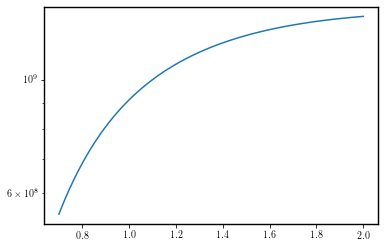

In [30]:
plt.plot(ztab, bstab)
plt.yscale('log')
plt.show()

In [31]:
def sb(k1,k2,k3):
    if k1==k2 and k2==k3:
        return 6.0
    elif (k1==k2 or k1==k3 or k2==k3):
        return 2.0
    else:
        return 1.0


In [44]:
def snr_bs(kmin,kmax,zmin,zmax,n_kbins,n_zbins,n_mubins):
    deltamu = 2.0/n_mubins
    deltaphi = (2.0*np.pi)/n_mubins
    deltak = (kmax-kmin)/n_kbins
    deltaz = (zmax-zmin)/n_zbins
    deltatheta = np.pi/(n_kbins/2.0)
    res=0.0
    for kk1 in np.arange(kmin, kmax+deltak, deltak):
        for kk2 in np.arange(kmin, kk1+deltak, deltak):
            for kk3 in np.arange(max(kmin,abs(kk1-kk2)), kk2+deltak, deltak):
                if (kk1+kk2>kk3 and kk1+kk3>kk2 and kk2+kk3>kk1)==True:
                    costheta = 0.5 * (kk3**2 - (kk1**2 + kk2**2))/(kk1*kk2)
                    costheta23=0.5* (kk1**2-(kk2**2 + kk3**2))/(kk2*kk3)
                    costheta13 = 0.5*(kk2**2 - kk1**2 - kk3**2)/(kk1*kk3)
                    for mmu in np.arange(-1.0, 1.0, deltamu):
                        for pphi in np.arange(0.0, (2.0*np.pi), deltaphi):
                            mmu2 = mmu*costheta + np.sqrt(1.0-mmu**2) * np.sqrt((1.0-costheta**2))*np.cos(pphi)
                            mmu3 = -(kk1/kk3)*mmu - (kk2/kk3)*mmu2
                            for zz in np.arange((zmin+(deltaz/2.0)), (zmax+(deltaz/2.0)), deltaz):
                                #print(mmu2)
                                ptw1 = ps_g(zz,kk1,mmu) + 1.0/ng_euclid(zz)
                                ptw2 = ps_g(zz,kk2,mmu2) + 1.0/ng_euclid(zz)
                                ptw3 = ps_g(zz,kk3,mmu3) + 1.0/ng_euclid(zz)
                                cb = sb(kk1,kk2,kk3) * ptw1 * ptw2 * ptw3
                                bsquared = bs_g(zz,kk1,kk2,kk3,mmu,pphi)**2
                                snrstep = v_euclid(zz) * deltaz * kk1 * kk2 * kk3 * deltak**3 * deltamu * deltaphi * bsquared * (1.0/(2.0*np.pi))**5 / cb
                                print(cb)
                                #snrstep = (1.0/32.0)* v_euclid(zz) * deltaz * kk1 * kk2 * kk3 * deltak**3 * deltamu * deltaphi * bs_g(zz,kk1,kk2,kk3,mmu,pphi)**2 / (np.pi**5 * (ps_g(zz,kk1,mmu) + 1.0/(ng_euclid(zz))) * (ps_g(zz,kk2,mmu2) + 1.0/(ng_euclid(zz))) * (ps_g(zz,kk3,mmu3) + 1.0/(ng_euclid(zz))) * sb(kk1,kk2,kk3))
                                res = res + snrstep
    return res

In [45]:
snr_bs(0.001,0.01,1.0,1.1, 20.0, 1.0,10.0)

71785901393477.7
71785901393477.7
71785901393477.7
71785901393477.7
71785901393477.7
71785901393477.7
71785901393477.7
71785901393477.7
71785901393477.7
71785901393477.7
71456951933822.62
61442243813864.9
47699639365951.35
47699639365951.36
61442243813864.88
71456951933822.62
61442243813864.89
47699639365951.37
47699639365951.35
61442243813864.89
71739095500830.17
54553369683500.93
33905302979131.05
33905302979131.043
54553369683500.914
71739095500830.17
54553369683500.93
33905302979131.05
33905302979131.043
54553369683500.914
71744772022188.12
49976616121487.5
26181788641156.434
26181788641156.43
49976616121487.484
71744772022188.12
49976616121487.51
26181788641156.438
26181788641156.434
49976616121487.484
71531156375863.8
47314332229825.14
22275269746276.68
22275269746276.684
47314332229825.13
71531156375863.8
47314332229825.15
22275269746276.688
22275269746276.68
47314332229825.125
71410806248876.9
46437179428606.664
21083313717501.375
21083313717501.37
46437179428606.66
71410806248

21478702795808.42
8547088811979.414
7147774269020.688
14393701368115.71
27125887480785.42
17275858819343.865
7398445108716.657
7398445108716.658
17275858819343.865
27125887480785.43
17275858819343.879
7398445108716.658
7398445108716.654
17275858819343.865
34046766568739.98
21478702795808.41
8547088811979.408
7147774269020.6875
14393701368115.713
21643927909216.598
14393701368115.715
7147774269020.6875
8547088811979.405
21478702795808.406
41764539759534.98
26967987048612.836
10825314259332.627
7786441577866.718
12688829823272.31
17621018301507.55
12688829823272.312
7786441577866.721
10825314259332.621
26967987048612.812
48046947617826.54
32930804238353.867
14636514699025.818
9607795364694.941
12148019560873.982
15017590867473.982
12148019560873.982
9607795364694.941
14636514699025.818
32930804238353.86
47713891006586.43
36523268706954.71
20307113593195.504
13516175869633.498
13308587404254.188
14256511881937.596
13308587404254.188
13516175869633.496
20307113593195.504
36523268706954.7
5

78306742158212.14
128600789542663.23
169927443947636.62
145345266480712.94
111847860719531.2
111847860719531.22
145345266480712.88
169927443947636.6
145345266480712.94
111847860719531.22
111847860719531.2
145345266480712.84
65473455429987.69
65473455429987.69
65473455429987.69
65473455429987.69
65473455429987.69
65473455429987.69
65473455429987.69
65473455429987.69
65473455429987.69
65473455429987.69
50914048674430.73
45410746316594.17
39797926115214.8
48853394753356.12
76615396044050.16
96173289847750.36
76615396044050.16
48853394753356.13
39797926115214.81
45410746316594.17
52076414579066.07
40693763227099.59
28149702417113.266
35086823576614.15
70069305967182.65
99482950065680.67
70069305967182.67
35086823576614.16
28149702417113.258
40693763227099.58
56465256068208.195
39765677042782.06
22146288567147.152
26434554286227.43
60734063738108.7
92684329604594.0
60734063738108.74
26434554286227.44
22146288567147.152
39765677042782.055
63127117098541.86
41473158701253.89
19524990892664.74

16945311207006.88
15643430106492.006
15643430106492.002
16945311207006.879
13064697687313.893
12265831708164.445
11057543570914.008
11057543570914.008
12265831708164.445
13064697687313.893
12265831708164.445
11057543570914.008
11057543570914.008
12265831708164.445
11760790181587.053
10983492625723.5
9814739788719.693
9814739788719.693
10983492625723.498
11760790181587.053
10983492625723.498
9814739788719.693
9814739788719.693
10983492625723.5
13064697687313.887
12265831708164.44
11057543570914.002
11057543570914.002
12265831708164.44
13064697687313.887
12265831708164.44
11057543570914.002
11057543570914.002
12265831708164.44
17793325265826.06
16945311207006.86
15643430106491.986
15643430106491.986
16945311207006.861
17793325265826.06
16945311207006.863
15643430106491.986
15643430106491.986
16945311207006.86
29169760624813.137
28310766072468.42
26968043037942.918
26968043037942.918
28310766072468.426
29169760624813.133
28310766072468.418
26968043037942.918
26968043037942.918
28310766072

39287100822644.805
56763629523725.56
71019380065155.3
56763629523725.57
39287100822644.805
42876283250069.71
72278081172965.5
101514382628319.34
85977358083299.39
63894058183438.53
59462846895791.945
70378038845208.45
78662557074350.77
70378038845208.45
59462846895791.98
63894058183438.516
85977358083299.39
86281457056232.52
86281457056232.52
86281457056232.52
86281457056232.52
86281457056232.52
86281457056232.52
86281457056232.52
86281457056232.52
86281457056232.52
86281457056232.52
83776406596882.02
71606286358896.02
53788371253286.68
49281900880875.31
55999765553274.586
61114764739747.164
55999765553274.59
49281900880875.3
53788371253286.664
71606286358896.02
73220916570351.0
56365654378597.29
34776351836992.15
31159488375053.016
41322682336660.05
49203712085489.375
41322682336660.05
31159488375053.023
34776351836992.15
56365654378597.29
61933756775046.266
44749254331575.62
24391839469717.137
22123196015123.156
34061439861529.36
43816992552802.52
34061439861529.363
22123196015123.16

40955237081772.41
30345226395941.637
30345226395941.633
40955237081772.4
48896446528213.26
40955237081772.41
30345226395941.633
30345226395941.637
40955237081772.4
41145466038725.01
33056684319200.6
22685116529083.215
22685116529083.215
33056684319200.598
41145466038725.01
33056684319200.605
22685116529083.215
22685116529083.215
33056684319200.598
38867522080213.625
30767343251172.137
20533685452265.234
20533685452265.234
30767343251172.137
38867522080213.61
30767343251172.137
20533685452265.234
20533685452265.234
30767343251172.137
41145466038725.0
33056684319200.582
22685116529083.203
22685116529083.2
33056684319200.582
41145466038724.984
33056684319200.582
22685116529083.2
22685116529083.203
33056684319200.574
48896446528213.234
40955237081772.37
30345226395941.613
30345226395941.613
40955237081772.37
48896446528213.23
40955237081772.37
30345226395941.613
30345226395941.613
40955237081772.37
65586651491224.53
58339619456673.09
48073728157425.19
48073728157425.19
58339619456673.09
65

KeyboardInterrupt: 

In [ ]:
np.arange(0.001,0.001,0.0016)

In [109]:
g=0.0028000000000000004
h=0.001
t=0.0018000000000000005

In [114]:
h+t>g

False

In [111]:
True and True and True

True